# Final Project by Shaig Hamzaliyev

**DUE September 16th, 23:59** (feedback session on September 23rd at 1:00 pm on BBB)

---

## Pixel and Image Classification on a Sentinel-2 Time Series

The final project is a combination of the homework assignments from days 4 and 5. By completing (or at least attempting to complete) these assignments and attending the homework feedback session on **August 14th at 1:00 pm on BBB**, there should be few issues with the tasks outlined here. For the final project please:

(a) Select a geographic area of interest (**not Golm, each student select a different region**) and download three (3) Sentinel-2 Level1C images separated by at least one year each using Google Earth Engine in Python. 
* **Note:** See Notebook 4a, make sure the bounding box for your area is maximum ~0.2 degrees in width and height. 
* **Note:** If you can't find cloud-free images you can raise the ```max_cloud_percent``` and try doing the classification steps with some clouds in the image.

(b) Create separate label shapefiles for each of the three images in your favorite GIS (may I suggest QGIS?). Use at least 5 label classes of your choosing (e.g., forest, desert, snow, buildings, roads, etc.). This depends on the content of your chosen geographic area! The classes should be the same between the different scenes. 
* **Note:** See the bottom of Notebook 4a for example label clicking.

(c) For each scene: use the training data you created to train a few ML models of your choice (at least 3 different models). Estimate the accuracy of your models via cross-validation. For at least one of the models you've trained, do a hyperparameter tuning, and report the accuracy computed via nested cross-validation. 

(d) For each scene: using the model with the highest accuracy, predict the land use labels on the entire scene.

* **Note:** See Notebooks 4b for dataset preparation steps and 4c for pre-processing and model running.

(e) Compare and discuss the results of your predicted land use labels in the three different scenes. Were there any problems? Do you note any clear land cover changes? Is this real change or error in the model?

(f) Using the EuroSAT RGB data, train a few CNNs with different architecture (at least two different architectures). Report their validation accuracy using a simple train-test split (or optionally, with a cross-validation loop). Optionally, try to regularize the best model to prevent overfitting (using, e.g., dropout layers, batchnormalization layers, etc.). 

(g) Pass each of the Sentinel scenes (tiled into 64\*64 pixel images) through the best CNN model to get predictions. Plot at least 20 tiles from each scene showing the same geographic area in each tile. 
* **Note:** See Notebook 5 for example.

(h) Compare and discuss the predictions on these tiles. Do the results look reasonable? What are the problems that you see? How could the predictions be improved and what are the limitations of this approach?

(i) Compare and discuss the results of the pixel versus the image classification on the Sentinel time series. Which method provided the best overall results and what were the limitations of each?

---

_**PLEASE NOTE:**_ Spend time making the figures look nice and write lots of descriptions of the steps in markdown cells between your code blocks. The better your figures look and the more you describe the steps you tried, the better your final grade will be. If the machine learning steps provide bad results, that's okay! The important thing is that you try the methods we learned in class on new data and see the limitations of machine learning for geoscientific applications on "noisy" data.

---

_**REMINDER**_ – Please submit all work as a SINGLE pdf file on Moodle. You can convert a jupyter notebook to a pdf via "File -> Download as -> PDF via LaTeX (.pdf)".

---

In [44]:
import ee
ee.Initialize()

In [45]:
collection = 'COPERNICUS/S2'
area_name = 'Siyazan'

In [46]:
drive_folder = 'chiraggala_sentinel2_level1C'
time_range = ['2016-09-01', '2016-09-30']
time_range1 = ['2017-07-01', '2017-07-30']
time_range2 = ['2020-06-01', '2020-06-30']
max_cloud_percent = 1

In [47]:
band_list = ['B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B11', 'B12']
spatial_resolution = 10

### Region of interest

My Region of interest is intersection of Siyazan and Shabran regions of Azerbaijan which includes ancient fortress Chirag Gala. Region is basically starting point of Caucasus mountain range. It is also close to Caspian sea, however my bounding box does not cover it. Region has forest, river(but does not have too much water in summer) artificial lake, agricultural fields and building which are mostly villages and small town of Shabran.

In [48]:
bbox_coords = [48.883366,41.041493,49.083366,41.241493] # Chiraggala

Here we will create image_collection's. Where we will apply our variables like: 'collection', 'max_cloud_percent' and 'time_range' as filters.

In [49]:
AOI = ee.Geometry.Rectangle(bbox_coords)
image_collection = ee.ImageCollection(collection).\
                     filterBounds(AOI).\
                     filterDate(time_range[0], time_range[1]).\
                     filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', max_cloud_percent))
image_collection1 = ee.ImageCollection(collection).\
                     filterBounds(AOI).\
                     filterDate(time_range1[0], time_range1[1]).\
                     filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', max_cloud_percent))
image_collection2 = ee.ImageCollection(collection).\
                     filterBounds(AOI).\
                     filterDate(time_range2[0], time_range2[1]).\
                     filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', max_cloud_percent))
first_img = image_collection.first()
first_img1 = image_collection1.first()
first_img2 = image_collection2.first()

In [7]:
# the image has metadata attached to it, let's have a quick look at that
first_img.getInfo()

{'type': 'Image',
 'bands': [{'id': 'B1',
   'data_type': {'type': 'PixelType',
    'precision': 'int',
    'min': 0,
    'max': 65535},
   'dimensions': [1830, 1830],
   'crs': 'EPSG:32639',
   'crs_transform': [60, 0, 300000, 0, -60, 4600020]},
  {'id': 'B2',
   'data_type': {'type': 'PixelType',
    'precision': 'int',
    'min': 0,
    'max': 65535},
   'dimensions': [10980, 10980],
   'crs': 'EPSG:32639',
   'crs_transform': [10, 0, 300000, 0, -10, 4600020]},
  {'id': 'B3',
   'data_type': {'type': 'PixelType',
    'precision': 'int',
    'min': 0,
    'max': 65535},
   'dimensions': [10980, 10980],
   'crs': 'EPSG:32639',
   'crs_transform': [10, 0, 300000, 0, -10, 4600020]},
  {'id': 'B4',
   'data_type': {'type': 'PixelType',
    'precision': 'int',
    'min': 0,
    'max': 65535},
   'dimensions': [10980, 10980],
   'crs': 'EPSG:32639',
   'crs_transform': [10, 0, 300000, 0, -10, 4600020]},
  {'id': 'B5',
   'data_type': {'type': 'PixelType',
    'precision': 'int',
    'min':

In [8]:
first_img1.getInfo()

{'type': 'Image',
 'bands': [{'id': 'B1',
   'data_type': {'type': 'PixelType',
    'precision': 'int',
    'min': 0,
    'max': 65535},
   'dimensions': [1830, 1830],
   'crs': 'EPSG:32639',
   'crs_transform': [60, 0, 300000, 0, -60, 4600020]},
  {'id': 'B2',
   'data_type': {'type': 'PixelType',
    'precision': 'int',
    'min': 0,
    'max': 65535},
   'dimensions': [10980, 10980],
   'crs': 'EPSG:32639',
   'crs_transform': [10, 0, 300000, 0, -10, 4600020]},
  {'id': 'B3',
   'data_type': {'type': 'PixelType',
    'precision': 'int',
    'min': 0,
    'max': 65535},
   'dimensions': [10980, 10980],
   'crs': 'EPSG:32639',
   'crs_transform': [10, 0, 300000, 0, -10, 4600020]},
  {'id': 'B4',
   'data_type': {'type': 'PixelType',
    'precision': 'int',
    'min': 0,
    'max': 65535},
   'dimensions': [10980, 10980],
   'crs': 'EPSG:32639',
   'crs_transform': [10, 0, 300000, 0, -10, 4600020]},
  {'id': 'B5',
   'data_type': {'type': 'PixelType',
    'precision': 'int',
    'min':

In [8]:
first_img2.getInfo()

{'type': 'Image',
 'bands': [{'id': 'B1',
   'data_type': {'type': 'PixelType',
    'precision': 'int',
    'min': 0,
    'max': 65535},
   'dimensions': [1830, 1830],
   'crs': 'EPSG:32639',
   'crs_transform': [60, 0, 300000, 0, -60, 4600020]},
  {'id': 'B2',
   'data_type': {'type': 'PixelType',
    'precision': 'int',
    'min': 0,
    'max': 65535},
   'dimensions': [10980, 10980],
   'crs': 'EPSG:32639',
   'crs_transform': [10, 0, 300000, 0, -10, 4600020]},
  {'id': 'B3',
   'data_type': {'type': 'PixelType',
    'precision': 'int',
    'min': 0,
    'max': 65535},
   'dimensions': [10980, 10980],
   'crs': 'EPSG:32639',
   'crs_transform': [10, 0, 300000, 0, -10, 4600020]},
  {'id': 'B4',
   'data_type': {'type': 'PixelType',
    'precision': 'int',
    'min': 0,
    'max': 65535},
   'dimensions': [10980, 10980],
   'crs': 'EPSG:32639',
   'crs_transform': [10, 0, 300000, 0, -10, 4600020]},
  {'id': 'B5',
   'data_type': {'type': 'PixelType',
    'precision': 'int',
    'min':

For file names we will use information from our first_img's metadata.

In [50]:
filename = '04_' + first_img.getInfo()['properties']['PRODUCT_ID'] + '_' + area_name+'16' + '_stacked_rescaled'
print(filename)
filename1 = '04_' + first_img1.getInfo()['properties']['PRODUCT_ID'] + '_' + area_name+'17' + '_stacked_rescaled'
print(filename1)
filename2 = '04_' + first_img2.getInfo()['properties']['PRODUCT_ID'] + '_' + area_name+'20' + '_stacked_rescaled'
print(filename2)

04_S2A_MSIL1C_20160921T073612_N0204_R092_T39TUF_20160921T074325_Siyazan16_stacked_rescaled
04_S2B_MSIL1C_20170703T073939_N0205_R092_T39TUF_20170703T074153_Siyazan17_stacked_rescaled
04_S2A_MSIL1C_20200602T073621_N0209_R092_T39TUF_20200602T094715_Siyazan20_stacked_rescaled


Next step is exporting images to our GDrive.

In [51]:
export_job = ee.batch.Export.image.toDrive(
        first_img.select(band_list).divide(10000), # we export only the selected bands and rescale by 10000
        description=filename, # we provide the filename for the raster
        folder=drive_folder, # we provide the destination folder on our Google Drive
        region=AOI.getInfo()['coordinates'], # we provide the region of interest for clipping
        scale=spatial_resolution) # and finally we provide the output spatial resolution
export_job.start()
print('job status: {}'.format(export_job.status()['state']))
export_job1 = ee.batch.Export.image.toDrive(
        first_img1.select(band_list).divide(10000),
        description=filename1, 
        folder=drive_folder, 
        region=AOI.getInfo()['coordinates'], 
        scale=spatial_resolution) 
export_job1.start()
print('job status: {}'.format(export_job1.status()['state']))
export_job2 = ee.batch.Export.image.toDrive(
        first_img2.select(band_list).divide(10000),
        description=filename2, 
        folder=drive_folder, 
        region=AOI.getInfo()['coordinates'], 
        scale=spatial_resolution) 
export_job2.start()
print('job status: {}'.format(export_job2.status()['state']))

job status: READY
job status: READY
job status: READY


In [52]:
print('job status: {}'.format(export_job.status()['state']))
print('job status: {}'.format(export_job1.status()['state']))
print('job status: {}'.format(export_job2.status()['state']))

job status: RUNNING
job status: READY
job status: READY


### Visualization


Now as I got files in my drive we can visualize them. For visualization I will plot all bands and then combine 3 bands (RGB). For reading data we are using rasterio library where we first will open our images and read them. Reading function will give us numpy array which is suitable for visualization.

In [53]:
import numpy as np
import rasterio
from rasterio.mask import mask
import geopandas as gpd
from shapely.geometry import mapping
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
chirag_gala17 = '04_S2B_MSIL1C_20170703T073939_N0205_R092_T39TUF_20170703T074153_Siyazan17_stacked_rescaled.tif'
full_dataset17 = rasterio.open(chirag_gala17)
chirag_gala16 = '04_S2A_MSIL1C_20160921T073612_N0204_R092_T39TUF_20160921T074325_Siyazan16_stacked_rescaled.tif'
full_dataset16 = rasterio.open(chirag_gala16)
chirag_gala20 = '04_S2A_MSIL1C_20200602T073621_N0209_R092_T39TUF_20200602T094715_Siyazan20_stacked_rescaled.tif'
full_dataset20 = rasterio.open(chirag_gala20)
n_bands = full_dataset16.count

In [54]:
band_list = ['B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B11', 'B12']

band_wavelengths = [490, 560, 665, 705, 740, 783, 842, 865, 1610, 2190]

As visualization of each band takes too much space I will plot each bands only for one of the images (2016).

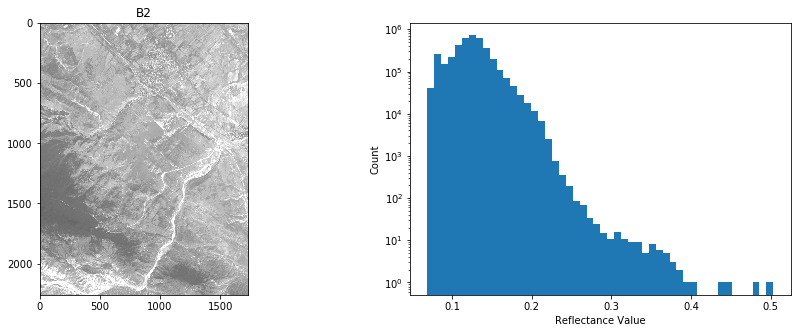

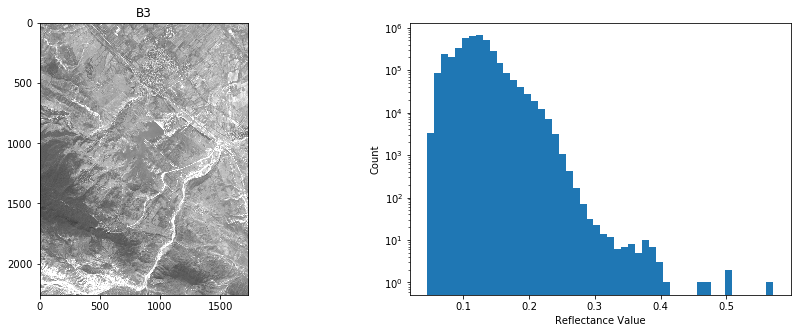

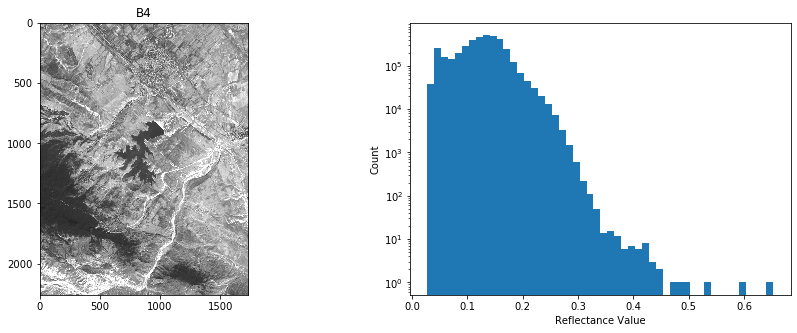

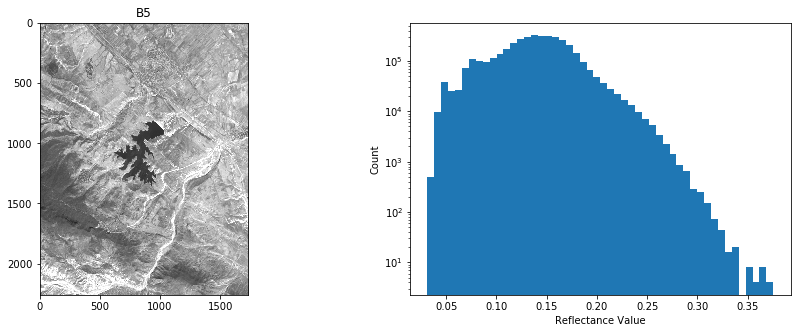

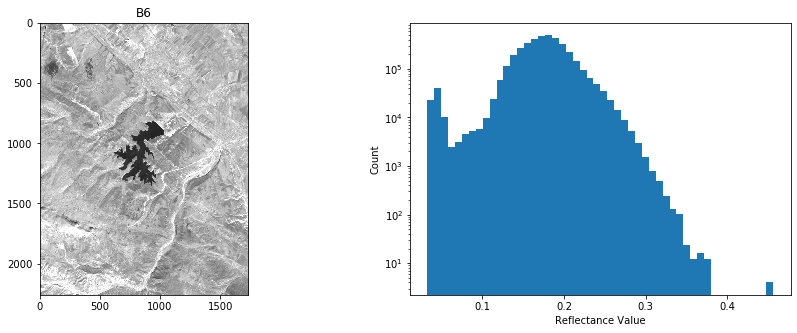

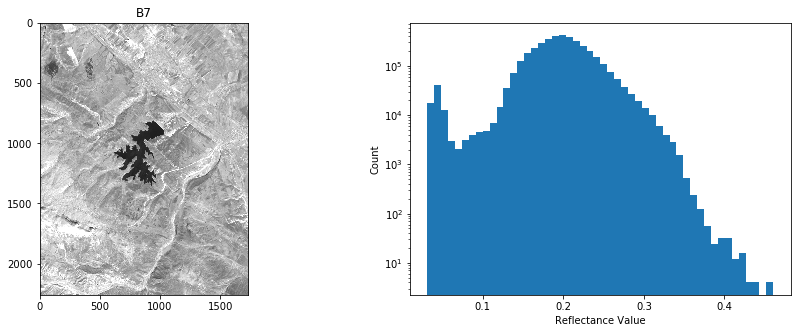

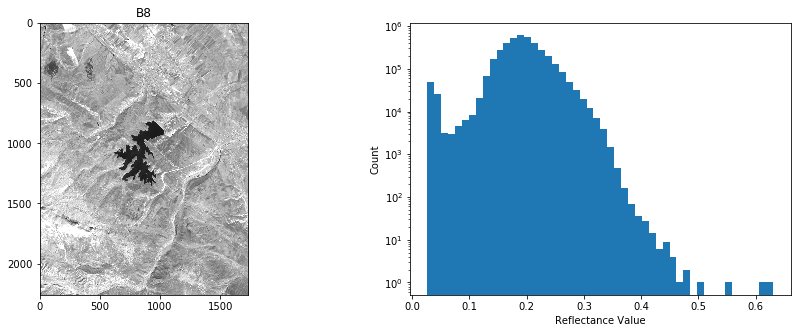

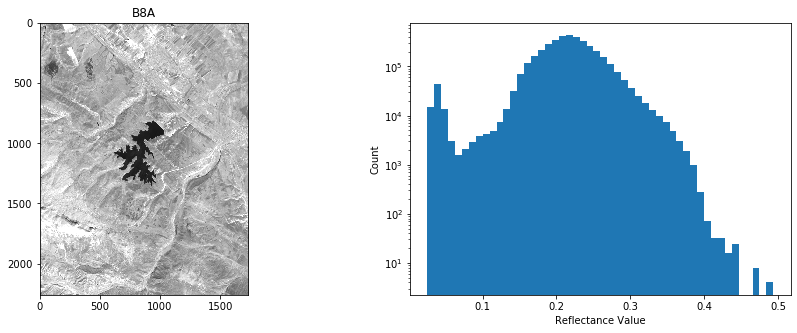

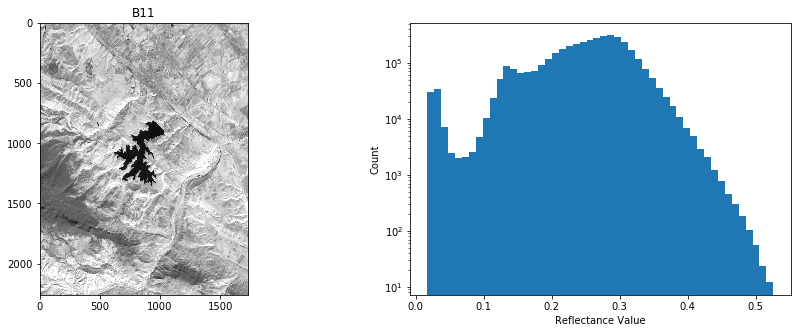

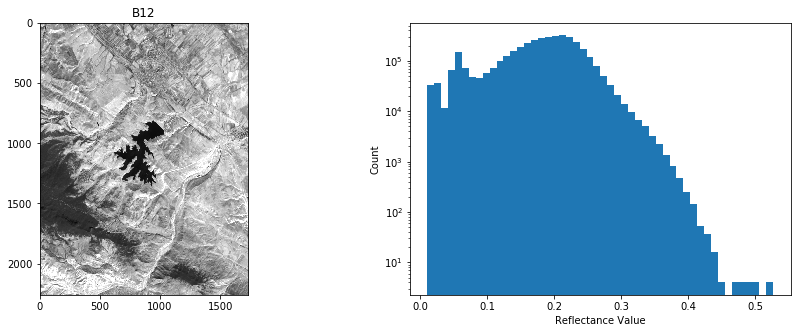

In [14]:
# visualize the bands
# read in each raster band and display it and a histogram of the values
for i in range(0, n_bands):
    img = full_dataset16.read(i+1)
    fig, ax = plt.subplots(1, 2, figsize=(15,5))
    ax[0].imshow(img, vmin=0, vmax=np.nanpercentile(img, 98), cmap='gray')
    ax[0].set_title(band_list[i])
    ax[1].hist(img.flatten(), bins=50)
    ax[1].set_yscale('log')
    ax[1].set_ylabel("Count")
    ax[1].set_xlabel("Reflectance Value")

Now RGB images. RGB bands are B4, B3, B2 for Sentinel 2. Indices for those bands would be [3, 2, 1]. We just need to change places of 1 and last dimension as matplotlib requires this structure for plotting RGB images.

In [55]:
RGB17 = full_dataset17.read([3, 2, 1])
RGB17 = np.moveaxis(RGB17, 0, -1)
RGB16 = full_dataset16.read([3, 2, 1])
RGB16 = np.moveaxis(RGB16, 0, -1)
RGB20 = full_dataset20.read([3, 2, 1])
print(RGB20.shape)
RGB20 = np.moveaxis(RGB20, 0, -1)
RGB20.shape

(3, 2260, 1731)


(2260, 1731, 3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, '2020 (RGB)')

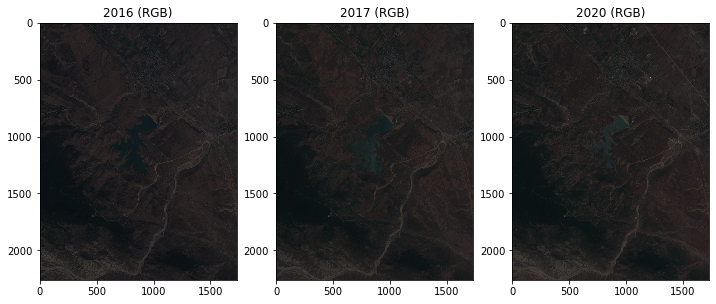

In [16]:
fig, ax = plt.subplots(1, 3, figsize = (12, 7))
ax[0].imshow(RGB16)
ax[0].set_title('2016 (RGB)')
ax[1].imshow(RGB17)
ax[1].set_title('2017 (RGB)')
ax[2].imshow(RGB20)
ax[2].set_title('2020 (RGB)')

In [72]:
RGB16.max(), RGB17.max(), RGB20.max(), RGB16.min(), RGB17.min(), RGB20.min()

(0.6529, 0.9824, 1.8572, 0.0275, 0.0356, 0.0161)

With original RGB values images do not seem too clear. The reason for that is most probaly value range for each image is different (Check previous cell for max & min values). So I will rescale images for better visualization. We will rescale values to 0-0.275 and reason is ESA is doing this way. But we can get fine images even if we will rescale values between 0-1.

In [56]:
# here we rescale the range 0-0.275 in our first three bands to 8-bit 1-255 (reserving 0 for no data)
!gdal_translate -of JPEG -co QUALITY=100 \
    -ot Byte -a_nodata 0 -scale 0 0.275 1 255 \
    -b 3 -b 2 -b 1 -of JPEG \
    04_S2B_MSIL1C_20170703T073939_N0205_R092_T39TUF_20170703T074153_Siyazan17_stacked_rescaled.tif \
    siyazan17.jpg

Input file size is 1731, 2260
0...10...20...30...40...50...60...70...80...90...100 - done.


In [57]:
# here we rescale the range 0-0.275 in our first three bands to 8-bit 1-255 (reserving 0 for no data)
!gdal_translate -of JPEG -co QUALITY=100 \
    -ot Byte -a_nodata 0 -scale 0 0.275 1 255 \
    -b 3 -b 2 -b 1 -of JPEG \
    04_S2A_MSIL1C_20160921T073612_N0204_R092_T39TUF_20160921T074325_Siyazan16_stacked_rescaled.tif \
    siyazan16.jpg

Input file size is 1731, 2260
0...10...20...30...40...50...60...70...80...90...100 - done.


In [58]:
!gdal_translate -of JPEG -co QUALITY=100 \
    -ot Byte -a_nodata 0 -scale 0 0.275 1 255 \
    -b 3 -b 2 -b 1 -of JPEG \
    04_S2A_MSIL1C_20200602T073621_N0209_R092_T39TUF_20200602T094715_Siyazan20_stacked_rescaled.tif \
    siyazan20.jpg

Input file size is 1731, 2260
0...10...20...30...40...50...60...70...80...90...100 - done.


Text(0.5, 1.0, '2020 (RGB)')

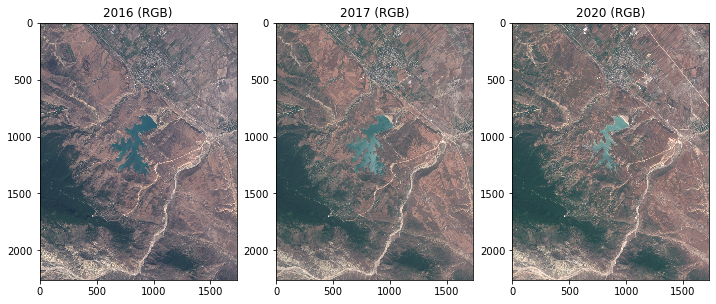

In [59]:
# let's load this image and plot it
rgb_fp20 = 'siyazan20.jpg'
rgb_fp17 = 'siyazan17.jpg'
rgb_fp16 = 'siyazan16.jpg'
img16 = mpimg.imread(rgb_fp16)
img17 = mpimg.imread(rgb_fp17)
img20 = mpimg.imread(rgb_fp20)
fig, ax = plt.subplots(1, 3, figsize = (12, 7))
ax[0].imshow(img16)
ax[0].set_title('2016 (RGB)')
ax[1].imshow(img17)
ax[1].set_title('2017 (RGB)')
ax[2].imshow(img20)
ax[2].set_title('2020 (RGB)')

In [73]:
project_to16 = full_dataset16.crs.to_dict()['init']
project_to17 = full_dataset17.crs.to_dict()['init']
project_to20 = full_dataset20.crs.to_dict()['init']
project_to16, project_to17, project_to20

('epsg:32639', 'epsg:32639', 'epsg:32639')

As we expected all three images have the same Projection!

In [74]:
label_fp16 = '/home/shaig93/Downloads/label_siyazan.shp'
label_fp17 = '/home/shaig93/Downloads/label_siyazan17.shp'
label_fp20 = '/home/shaig93/Downloads/label_siyazan20.shp'

In [75]:
# now load the shapefile using geopandas and check it's projection
shapefile16 = gpd.read_file(label_fp16)
shapefile17 = gpd.read_file(label_fp17)
shapefile20 = gpd.read_file(label_fp20)

# print the head
print(shapefile16.head())

print('\nthere are {} labels'.format(len(shapefile16)))

print('\nthe labels are {}'.format(np.unique(shapefile16.classname)))

print('\nthere are {} labels'.format(len(shapefile17)))

print('\nthe labels are {}'.format(np.unique(shapefile17.classname)))

print('\nthere are {} labels'.format(len(shapefile20)))

print('\nthe labels are {}'.format(np.unique(shapefile20.classname)))

# shapefile = shapefile.to_crs({'init': 'epsg:4326'})
print('\n2016 projection is: {}'.format(shapefile16.crs))
print('\n2017 projection is: {}'.format(shapefile17.crs))
print('\n2020 projection is: {}'.format(shapefile20.crs))

  classname                                           geometry
0     water  POLYGON ((48.96428 41.12873, 48.96532 41.12737...
1     water  POLYGON ((48.97499 41.13343, 48.97515 41.13280...
2     water  POLYGON ((48.99518 41.16672, 48.99474 41.16595...
3    forest  POLYGON ((48.88513 41.11227, 48.88572 41.11100...
4    forest  POLYGON ((48.89649 41.11660, 48.89670 41.11578...

there are 34 labels

the labels are ['agr_field' 'forest' 'river_basin' 'road' 'roof' 'water']

there are 25 labels

the labels are ['agr_field' 'forest' 'river_basin' 'road' 'roof' 'water']

there are 31 labels

the labels are ['agr_field' 'forest' 'river_basin' 'road' 'roof' 'water']

2016 projection is: epsg:4326

2017 projection is: epsg:4326

2020 projection is: epsg:4326


Our polygons have different projections than our images, as we did not change them in QGIS (we could have done that there too). In next cell we will use geopandas's 'to_crs()' method for putting them into the same projection with our images.

In [76]:
# we need to put the data in the same projection first, easy with geopandas
shapefile16 = shapefile16.to_crs(project_to16)
print('2016 projection is now: {}'.format(shapefile16.crs))
shapefile17 = shapefile17.to_crs(project_to17)
print('2017 projection is now: {}'.format(shapefile17.crs))
shapefile20 = shapefile20.to_crs(project_to20)
print('2020 projection is now: {}'.format(shapefile20.crs))

2016 projection is now: epsg:32639
2017 projection is now: epsg:32639
2020 projection is now: epsg:32639


current polygon is of class: water

vertices of the current polygon are: POLYGON ((331812.0710640098 4559201.890435769, 331773.6170804087 4559117.291671847, 331708.2453082874 4559136.518663649, 331812.0710640098 4559201.890435769))

and this shape looks like:


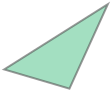

In [77]:
# this generates a list of shapely geometries
geoms16 = shapefile16.geometry.values 
geoms17 = shapefile17.geometry.values 
geoms20 = shapefile20.geometry.values 

# to show you what this looks like let's grab a random polygon in the shapefile
geometry16 = geoms16[2] 
geometry17 = geoms17[2] 
geometry20 = geoms20[2] 
classname16 = shapefile16['classname'][2]
classname17 = shapefile17['classname'][2]
classname20 = shapefile20['classname'][2]
print('current polygon is of class: {}'.format(classname16))
print('\nvertices of the current polygon are: {}'.format(geometry16))
print('\nand this shape looks like:')
geometry16

Image in the above is our polygon however as we are working with pixels in next cell we will check pixel representation of our Polygon.

Masked area shape is: (10, 10, 12)

So this clip (with class water) is a 10 by 12 pixel stack of the 10 Sentinel bands.

And the first band looks like so:


Text(0.5, 1.0, 'B2')

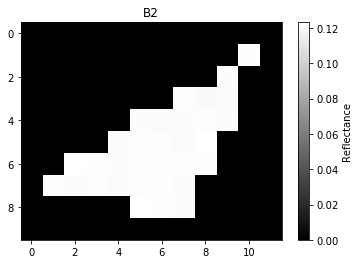

In [78]:
# transform to GeoJSON format using rasterio 'mapping' function
feature16 = [mapping(geometry16)]

# and finaly pull out the the pixel values with mask
out_image = mask(full_dataset16, feature16, crop=True, filled=True)[0]
print('Masked area shape is: {}'.format(out_image.shape))

print('\nSo this clip (with class {}) is a {} by {} pixel stack of the {} Sentinel bands.'
      .format(classname16, out_image.shape[1], out_image.shape[2], out_image.shape[0]))

print('\nAnd the first band looks like so:')

fig, ax = plt.subplots(1,1)
im = ax.imshow(out_image[0], cmap='gray')
fig.colorbar(im, ax=ax, label='Reflectance')
ax.set_title('{}'.format(band_list[0]))

Next step is creating variables (empty numpy arrays) which will represent data (RGB values for each pixel - X) and corresponding classname (water, roof etc. - y).

In [79]:
# pixels for training
X16 = np.array([], dtype=np.float32).reshape(n_bands, -1)
# labels for training
y16 = np.array([], dtype=np.string_)
X17 = np.array([], dtype=np.float32).reshape(n_bands, -1)
y17 = np.array([], dtype=np.string_)
X20 = np.array([], dtype=np.float32).reshape(n_bands, -1)
y20 = np.array([], dtype=np.string_)

Next step is filling empty arrays that we created above. We will loop through geometries by enumerate function which will allow us using both objects themselves and their indices. In the end y will be a 1D array as there is only one corresponding classname for each pixel, however X will be a matrix as there are 10 values (bands) for each pixel.

In [82]:
# looping over geometries 2016
for index, geom in enumerate(geoms16):
    # get the current polygon
    feature16 = [mapping(geom)]
    # get the classname for the polygon
    classname16 = shapefile16['classname'][index]
    # the mask function returns an array of the raster pixels within this polygon
    out_image16 = mask(full_dataset16, feature16, nodata=0, crop=True)[0]
    # eliminate all the pixels with 0 values for all bands - AKA not actually part of the shapefile
    out_image16 = out_image16[:, ~np.all(out_image16 == 0, axis=0)]
    # append the labels to the y array
    y16 = np.append(y16, [classname16] * out_image16.shape[1]) 
    # stack the pixels onto the pixel array
    X16 = np.hstack((X16, out_image16))

In [97]:
# looping over geometries 2017
for index, geom in enumerate(geoms17):
    feature17 = [mapping(geom)]
    classname17 = shapefile17['classname'][index]
    out_image17 = mask(full_dataset17, feature17, nodata=0, crop=True)[0]
    out_image17 = out_image17[:, ~np.all(out_image17 == 0, axis=0)]
    y17 = np.append(y17, [classname17] * out_image17.shape[1]) 
    X17 = np.hstack((X17, out_image17))

In [98]:
# looping over geometries 2020
for index, geom in enumerate(geoms20):
    feature20 = [mapping(geom)]
    classname20 = shapefile20['classname'][index]
    out_image20 = mask(full_dataset20, feature20, nodata=0, crop=True)[0]
    out_image20 = out_image20[:, ~np.all(out_image20 == 0, axis=0)]
    y20 = np.append(y20, [classname20] * out_image20.shape[1]) 
    X20 = np.hstack((X20, out_image20))

Now we can check our X's and y's. Also we can check our classname for each year and see if they are same or not.

In [99]:
# What are our classification labels?
labels = np.unique(shapefile16["classname"])
labels17 = np.unique(shapefile17["classname"])
labels20 = np.unique(shapefile20["classname"])
print('The training data 2016 include {} classes: {}\n'.format(labels.size, labels))
print('The training data 2017 include {} classes: {}\n'.format(labels17.size, labels17))
print('The training data 2020 include {} classes: {}\n'.format(labels20.size, labels20))

# We will need a "X" matrix containing our features, and a "y" array containing our labels
print('Our X 2016 matrix is sized: {}'.format(X16.shape))
print('Our y 2016 array is sized: {}'.format(y16.shape))
print('Our X 2017 matrix is sized: {}'.format(X17.shape))
print('Our y 2017 array is sized: {}'.format(y17.shape))
print('Our X 2020 matrix is sized: {}'.format(X20.shape))
print('Our y 2020 array is sized: {}'.format(y20.shape))

The training data 2016 include 6 classes: ['agr_field' 'forest' 'river_basin' 'road' 'roof' 'water']

The training data 2017 include 6 classes: ['agr_field' 'forest' 'river_basin' 'road' 'roof' 'water']

The training data 2020 include 6 classes: ['agr_field' 'forest' 'river_basin' 'road' 'roof' 'water']

Our X 2016 matrix is sized: (10, 732)
Our y 2016 array is sized: (732,)
Our X 2017 matrix is sized: (10, 1737)
Our y 2017 array is sized: (1737,)
Our X 2020 matrix is sized: (10, 879)
Our y 2020 array is sized: (879,)


We do have same classnames. Now we can check mean of reflectance values for each band. We have been provided with a loop for that in the lecture but as now we have 3 images I am putting same loop from lecture inside another loop for plotting them all in one figure.

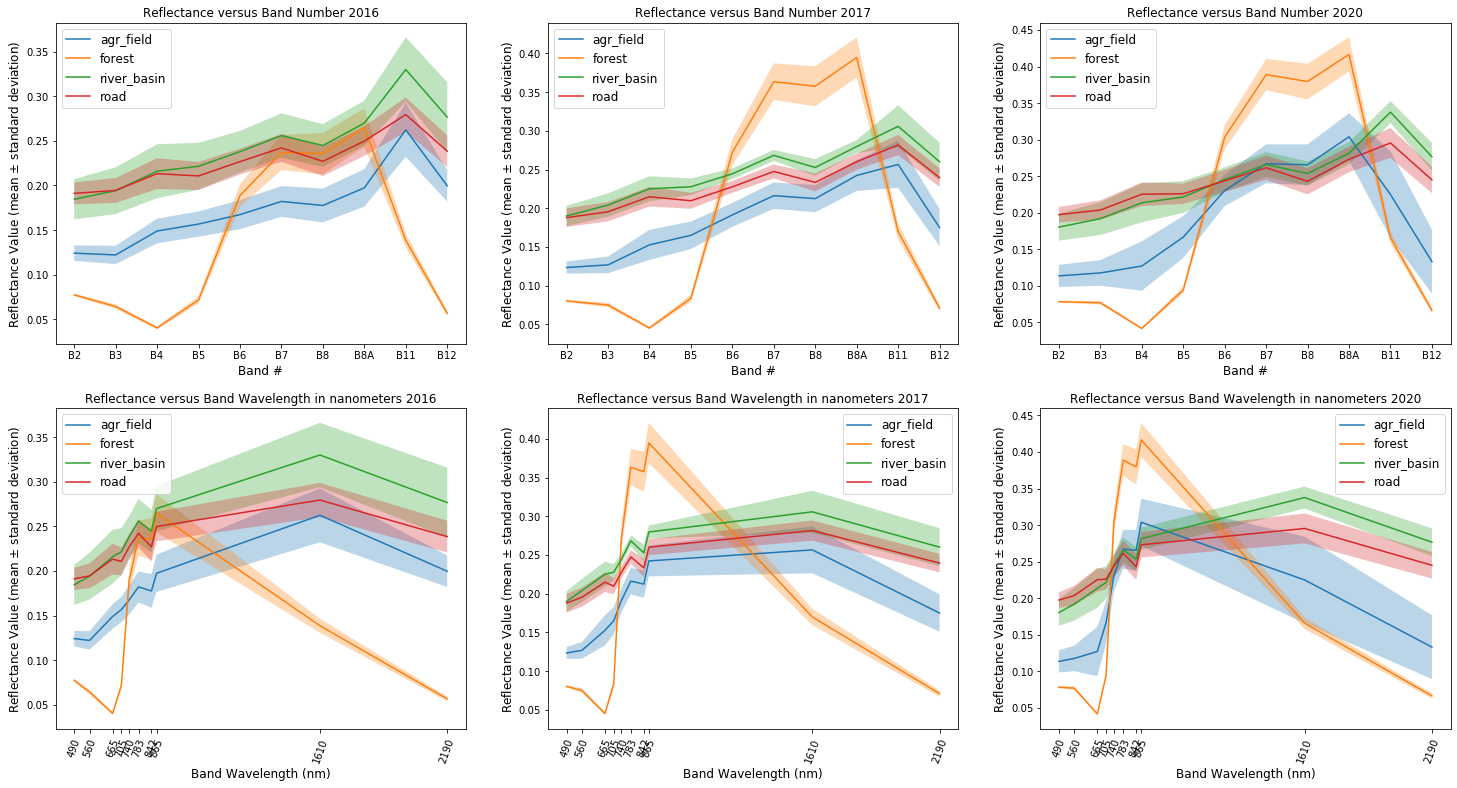

In [29]:
fig, axs = plt.subplots(2,3, figsize=(25,13))

all_labels = ['agr_field', 'forest', 'river_basin', 'road', 'roof', 'water']

labels_to_plot = ['agr_field', 'forest', 'river_basin', 'road']
date = ['2016', '2017', '2020']
# loop through classes and plot the mean in each band
for i in range(3):
    bands = range(1, n_bands+1)
    for label in labels_to_plot:
        mean16 = np.mean(X16[:, y16==label], axis=1)
        std16 = np.std(X16[:, y16==label], axis=1)
        mean17 = np.mean(X17[:, y17==label], axis=1)
        std17 = np.std(X17[:, y17==label], axis=1)
        mean20 = np.mean(X20[:, y20==label], axis=1)
        std20 = np.std(X20[:, y20==label], axis=1)
        mn = [mean16, mean17, mean20]
        std = [std16, std17, std20]
        axs[0, i].fill_between(bands, mn[i]-std[i], mn[i]+std[i], alpha=0.3)
        axs[0, i].plot(bands, mn[i], label=label)
        axs[1, i].fill_between(band_wavelengths, mn[i]-std[i], mn[i]+std[i], alpha=0.3)
        axs[1, i].plot(band_wavelengths, mn[i], label=label)
    axs[0, i].set_xticks(bands)
    axs[0, i].set_xticklabels(band_list)
    axs[0, i].set_xlabel('Band #', fontsize=12)
    axs[0, i].set_ylabel('Reflectance Value (mean $\pm$ standard deviation)', fontsize=12)
    axs[0, i].legend(fontsize=12)
    axs[0, i].set_title('Reflectance versus Band Number'+' '+date[i], fontsize=12)
    axs[1, i].set_xticks(band_wavelengths)
    axs[1, i].tick_params('x', labelrotation=70)
    axs[1, i].set_xlabel('Band Wavelength (nm)', fontsize=12)
    axs[1, i].set_ylabel('Reflectance Value (mean $\pm$ standard deviation)', fontsize=12)
    axs[1, i].legend(fontsize=12)
    axs[1, i].set_title('Reflectance versus Band Wavelength in nanometers'+' '+date[i], fontsize=12)

In [100]:
# first reshape the X array for passing to classifiers
X16_reshape = X16.T
X17_reshape = X17.T
X20_reshape = X20.T
print(X16.shape, X16_reshape.shape), print(X17.shape, X17_reshape.shape), print(X20.shape, X20_reshape.shape)

(10, 732) (732, 10)
(10, 1737) (1737, 10)
(10, 879) (879, 10)


(None, None, None)

After reshaping we can save our arrays as a .npy files so we will not need to run previous cells again.

In [101]:
# now save out the pixel values
with open('16_pixel_bands.npy', 'wb') as f:
    np.save(f, X16_reshape)
# and save the associated class of each pixel
with open('16_pixel_band_classes.npy', 'wb') as f:
    np.save(f, y16)
with open('17_pixel_bands.npy', 'wb') as f:
    np.save(f, X17_reshape)
with open('17_pixel_band_classes.npy', 'wb') as f:
    np.save(f, y17)
with open('20_pixel_bands.npy', 'wb') as f:
    np.save(f, X20_reshape)
with open('20_pixel_band_classes.npy', 'wb') as f:
    np.save(f, y20)

In [102]:
import os
import matplotlib as mpl
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import rasterio
from sklearn.preprocessing import StandardScaler, QuantileTransformer, PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score, GridSearchCV, StratifiedShuffleSplit, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import Perceptron
from sklearn.neural_network import MLPClassifier

In [103]:
sentinel_fp16 = '04_S2A_MSIL1C_20160921T073612_N0204_R092_T39TUF_20160921T074325_Siyazan16_stacked_rescaled.tif'
full_dataset16 = rasterio.open(sentinel_fp16)
sentinel_fp16 = '04_S2B_MSIL1C_20170703T073939_N0205_R092_T39TUF_20170703T074153_Siyazan17_stacked_rescaled.tif'
full_dataset16 = rasterio.open(sentinel_fp16)
sentinel_fp16 = '04_S2A_MSIL1C_20200602T073621_N0209_R092_T39TUF_20200602T094715_Siyazan20_stacked_rescaled.tif'
full_dataset16 = rasterio.open(sentinel_fp16)
print(full_dataset16.meta)

# save width and height for later reshaping
width16 = full_dataset16.meta['width']
height16 = full_dataset16.meta['height']
width17 = full_dataset17.meta['width']
height17 = full_dataset17.meta['height']
width20 = full_dataset20.meta['width']
height20 = full_dataset20.meta['height']

{'driver': 'GTiff', 'dtype': 'float32', 'nodata': None, 'width': 1731, 'height': 2260, 'count': 10, 'crs': CRS.from_epsg(32639), 'transform': Affine(10.0, 0.0, 322090.0,
       0.0, -10.0, 4567730.0)}


In previous cell we saved width and height of our images by using metadata. Next step is loading our .npy files and creating variables for prediction images. However we need to reshape our images and flatten them. It means before we had 3d data (tensors). It means 2 dimension is image it self 3rd is bands. We are flattenning image so we are ending up with something like that (n, 10). 

In [117]:
# load training data
X16 = np.load('16_pixel_bands.npy')
y16 = np.load('16_pixel_band_classes.npy')
X17 = np.load('17_pixel_bands.npy')
y17 = np.load('17_pixel_band_classes.npy')
X20 = np.load('20_pixel_bands.npy')
y20 = np.load('20_pixel_band_classes.npy')
# load prediction image
X_pred16 = full_dataset16.read()
X_pred17 = full_dataset17.read()
X_pred20 = full_dataset20.read()
print(X_pred16.shape)
# adjust the axis to move band axis to the last dimension
X_pred16 = np.moveaxis(X_pred16, 0, -1)
X_pred17 = np.moveaxis(X_pred17, 0, -1)
X_pred20 = np.moveaxis(X_pred20, 0, -1)
print(X_pred16.shape)
# finally reshape to create array of pixels and values
fx16, fx17, fx20 = [], [], []
for i in range(10):
    fx16.append(X_pred16[:, :, i].flatten())
    fx17.append(X_pred17[:, :, i].flatten())
    fx20.append(X_pred20[:, :, i].flatten())
X_pred16 = np.array(fx16).T
X_pred17 = np.array(fx17).T
X_pred20 = np.array(fx20).T
print(X_pred16.shape)

(10, 2260, 1731)
(2260, 1731, 10)
(3912060, 10)


Next step is shuffling positions of our values. First we are creating an array according to the length of our data but the order of elments will be random and then we are using it as indicies for our original data.

In [119]:
# shuffle X, y
rp16 = np.random.permutation(len(X16))
rp17 = np.random.permutation(len(X17))
rp20 = np.random.permutation(len(X20))
X16 = X16[rp16]
y16 = y16[rp16]
X17 = X17[rp17]
y17 = y17[rp17]
X20 = X20[rp20]
y20 = y20[rp20]

In [121]:
print(X16.shape, X_pred16.shape, y16.shape)
print(X17.shape, X_pred17.shape, y17.shape)
print(X20.shape, X_pred20.shape, y20.shape)

(732, 10) (3912060, 10) (732,)
(1737, 10) (3912060, 10) (1737,)
(879, 10) (3912060, 10) (879,)


In [131]:
print(X16.dtype, X_pred16.dtype, y16.dtype)

float32 float32 <U11


In [123]:
# mean values for each band 
print(X16.mean(axis=0)) 
print(X17.mean(axis=0))
print(X20.mean(axis=0))
print(X16.std(axis=0))
print(X17.std(axis=0))
print(X20.std(axis=0))

[0.16338204 0.16138025 0.16465975 0.16453934 0.19356877 0.21230666
 0.20298238 0.22197211 0.22864805 0.18384509]
[0.12269212 0.12195767 0.10755054 0.12341898 0.21218695 0.26075807
 0.25210097 0.28094962 0.18699642 0.11955579]
[0.15745331 0.16053097 0.15191166 0.16153218 0.20099385 0.22527383
 0.21399127 0.2396553  0.20246483 0.1485448 ]
[0.05323115 0.05901897 0.0768659  0.06702467 0.06285939 0.06911327
 0.06924994 0.07414872 0.09688075 0.09445339]
[0.04336984 0.04745654 0.06583089 0.05244638 0.07160065 0.10484552
 0.10746494 0.11660435 0.07662067 0.07250194]
[0.04952558 0.05126042 0.06631015 0.05544146 0.07327374 0.09059026
 0.09548528 0.10176466 0.10204    0.08999638]


Here we will create dataframes for each year where number of rows will represent number of pixels and coulmns will represent number of bands + classnames. Then by using value_counts() method we can check number of pixels for each unique classname.

In [124]:
# show label counts
df16 = pd.DataFrame(X16)
df17 = pd.DataFrame(X17)
df20 = pd.DataFrame(X20)
df16['label'] = y16
df17['label'] = y17
df20['label'] = y20
df16.label.value_counts(),df17.label.value_counts(),df20.label.value_counts()

(road           282
 forest         109
 water           96
 roof            94
 river_basin     87
 agr_field       64
 Name: label, dtype: int64,
 forest         735
 water          352
 agr_field      307
 road           181
 roof            95
 river_basin     67
 Name: label, dtype: int64,
 water          309
 agr_field      199
 road           107
 river_basin     99
 roof            91
 forest          74
 Name: label, dtype: int64)

Before applying ML algorithms I want to mention that I did not reduce number of bands I decided to use 10 bands for hoping better results.

In [127]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
clf = make_pipeline(StandardScaler(), RandomForestClassifier())
scores16 = cross_val_score(clf, X16, y16, cv=5)
scores17 = cross_val_score(clf, X16, y16, cv=5)
scores20 = cross_val_score(clf, X16, y16, cv=5)
print('Score16 (accuracy): ', scores16.mean())
print('Score17 (accuracy): ', scores17.mean())
print('Score20 (accuracy): ', scores20.mean())

Score16 (accuracy):  0.9603764793588667
Score17 (accuracy):  0.9562762091137825
Score20 (accuracy):  0.9617463423725654


First algorithm that I chose is Random Forest. Here I checked how our chosen algorihm will perform by cross validation. I did not do hyperparameter tuning for know and scores seems quite well. I found a visualization method which gives nice inside about cross validation. I will not visualize this graph for next algorithms for the sake of space.

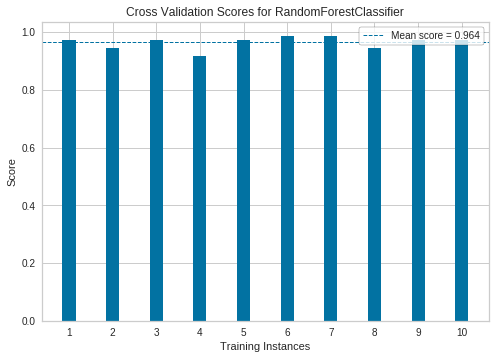

In [129]:
from yellowbrick.model_selection import CVScores

visualizer = CVScores(clf, cv=10)#, scoring='f1_weighted')

visualizer.fit(X16, y16)
visualizer.show()

Now I am going to do hyperparameter tuning. Every algorithm has different parameters. In scikit-learn library they all have mentioned with small explenation with there default values. However it is good to mention that those parameter names that has been mentioned in scikit library are not appropriate as an argument. For getting exact argument names we can just use this line 'clf.get_params().keys()'. For hyperparameter tuning we just need to choose certain parameters and give them couple of options. For example in this case I am tuning number of trees and max_features. I am giving 3 options for number of estimators and 2 options for max_features, so in the end I am expecting 6 different results (because it will check all combinations) and we will be able to check best combination based on the accuracy score.

In [130]:
clf.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'standardscaler', 'randomforestclassifier', 'standardscaler__copy', 'standardscaler__with_mean', 'standardscaler__with_std', 'randomforestclassifier__bootstrap', 'randomforestclassifier__ccp_alpha', 'randomforestclassifier__class_weight', 'randomforestclassifier__criterion', 'randomforestclassifier__max_depth', 'randomforestclassifier__max_features', 'randomforestclassifier__max_leaf_nodes', 'randomforestclassifier__max_samples', 'randomforestclassifier__min_impurity_decrease', 'randomforestclassifier__min_impurity_split', 'randomforestclassifier__min_samples_leaf', 'randomforestclassifier__min_samples_split', 'randomforestclassifier__min_weight_fraction_leaf', 'randomforestclassifier__n_estimators', 'randomforestclassifier__n_jobs', 'randomforestclassifier__oob_score', 'randomforestclassifier__random_state', 'randomforestclassifier__verbose', 'randomforestclassifier__warm_start'])

In [132]:
from sklearn.model_selection import GridSearchCV

rndm16 = GridSearchCV(estimator=clf, param_grid={'randomforestclassifier__n_estimators': [110, 130, 150], 'randomforestclassifier__max_features': ['auto', 'sqrt']}, cv=10, refit=True, return_train_score=False, verbose=0)
rndm17 = GridSearchCV(estimator=clf, param_grid={'randomforestclassifier__n_estimators': [110, 130, 150], 'randomforestclassifier__max_features': ['auto', 'sqrt']}, cv=10, refit=True, return_train_score=False, verbose=0)
rndm20 = GridSearchCV(estimator=clf, param_grid={'randomforestclassifier__n_estimators': [110, 130, 150], 'randomforestclassifier__max_features': ['auto', 'sqrt']}, cv=10, refit=True, return_train_score=False, verbose=0)

rndm16.fit(X16, y16)
rndm17.fit(X16, y16)
rndm20.fit(X16, y16)

cv_results16 = pd.DataFrame(rndm16.cv_results_)
cv_results16

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0       0.155991      0.008563         0.007167        0.000464   
1       0.180189      0.000981         0.008369        0.000094   
2       0.221701      0.009737         0.009912        0.000436   
3       0.163733      0.008850         0.007663        0.000456   
4       0.191667      0.004997         0.008813        0.000261   
5       0.221494      0.002614         0.010045        0.000183   

  param_randomforestclassifier__max_features  \
0                                       auto   
1                                       auto   
2                                       auto   
3                                       sqrt   
4                                       sqrt   
5                                       sqrt   

  param_randomforestclassifier__n_estimators  \
0                                        110   
1                                        130   
2                                        150   
3                                        110   
4                                        130   
5                                        150   

                                              params  split0_test_score  \
0  {'randomforestclassifier__max_features': 'auto...           0.972973   
1  {'randomforestclassifier__max_features': 'auto...           0.972973   
2  {'randomforestclassifier__max_features': 'auto...           0.972973   
3  {'randomforestclassifier__max_features': 'sqrt...           0.972973   
4  {'randomforestclassifier__max_features': 'sqrt...           0.972973   
5  {'randomforestclassifier__max_features': 'sqrt...           0.972973   

   split1_test_score  split2_test_score  split3_test_score  split4_test_score  \
0           0.945946           0.972603           0.917808           0.972603   
1           0.945946           0.972603           0.917808           0.986301   
2           0.945946           0.972603           0.917808           0.958904   
3           0.945946           0.972603           0.917808           0.958904   
4           0.945946           0.972603           0.917808           0.958904   
5           0.945946           0.986301           0.917808           0.986301   

   split5_test_score  split6_test_score  split7_test_score  split8_test_score  \
0           0.986301           0.958904           0.945205           0.945205   
1           0.986301           0.972603           0.945205           0.945205   
2           0.972603           0.972603           0.945205           0.958904   
3           0.986301           0.986301           0.931507           0.958904   
4           0.986301           0.958904           0.945205           0.945205   
5           0.986301           0.986301           0.945205           0.958904   

   split9_test_score  mean_test_score  std_test_score  rank_test_score  
0           0.958904         0.957645        0.018815                6  
1           0.972603         0.961755        0.021007                2  
2           0.972603         0.959015        0.017300                4  
3           0.972603         0.960385        0.021587                3  
4           0.972603         0.957645        0.018815                5  
5           0.972603         0.965864        0.022244                1

In [133]:
rndm16.best_params_, rndm16.best_score_

({'randomforestclassifier__max_features': 'sqrt',
  'randomforestclassifier__n_estimators': 150},
 0.9658644946316179)

In [134]:
rndm17.best_params_, rndm17.best_score_

({'randomforestclassifier__max_features': 'sqrt',
  'randomforestclassifier__n_estimators': 130},
 0.9631247686042208)

In [136]:
rndm20.best_params_, rndm20.best_score_

({'randomforestclassifier__max_features': 'sqrt',
  'randomforestclassifier__n_estimators': 150},
 0.961754905590522)

Our best score for 2016 is 0.965 which is an improvement but not big one. For 2017 improvement is almost 1 percent but there is almost no change in 2020 score. In next cell I am going to check Nested cross validation scores.

In [137]:
Acc16 = cross_val_score(rndm16, X16, y16)
Acc17 = cross_val_score(rndm17, X17, y17)
Acc20 = cross_val_score(rndm20, X20, y20)
print('Nested CV 2016: ', Acc16.mean(), Acc16.std())
print('Nested CV 2017: ', Acc17.mean(), Acc17.std())
print('Nested CV 2020: ', Acc20.mean(), Acc20.std())

Nested CV 2016:  0.9562762091137825 0.018190652632913477
Nested CV 2017:  0.993093510881447 0.00533468060442419
Nested CV 2020:  0.9806688311688312 0.005776542499200239


Next step is actual validation of our algorithms on image. We will predict classes for each pixel. But before that as we falttened our arrays we need to reshape them back as we want to plot the prediction result as an image.

In [138]:
# original shape of scene
orig_shape16 = (height16, width16)
orig_shape17 = (height17, width17)
orig_shape20 = (height20, width20)

# run prediction on the image
y_pred16 = rndm16.predict(X_pred16)
y_pred17 = rndm17.predict(X_pred17)
y_pred20 = rndm20.predict(X_pred20)
# reshape y back to a 2D matrix for visualization
y_pred_img16 = y_pred16.reshape(orig_shape16)
y_pred_img17 = y_pred17.reshape(orig_shape17)
y_pred_img20 = y_pred20.reshape(orig_shape20)

Our classnames are strings but it is not very useful. The reason is when we will visualize results we will assign different color for each class and we need to assign integer for each unique string. I used method that we learned in class. However it is also possible to use LabelEncoder() from scikit preprocessing. For example:


from sklearn import preprocessing

le = preprocessing.LabelEncoder()

le.fit(y_pred16)

le.transform(y_pred16)

Idea is simple however I think it would be useful to give some explanation for next cell. First of all we use enumerate for looping through labels. As we are using enumerate we have access to both indices and label names. Basically idea is we are assigning index ( i ) of certain label instead of it's name ([y_pred_img16 == label] ).

In [142]:
# reclassify the string label names as numeric values
labels = np.unique(shapefile16["classname"])
for i, label in enumerate(labels):
    y_pred_img16[y_pred_img16 == label] = i
    y_pred_img17[y_pred_img17 == label] = i
    y_pred_img20[y_pred_img20 == label] = i
y_pred_img16 = y_pred_img16.astype(int)
y_pred_img17 = y_pred_img17.astype(int)
y_pred_img20 = y_pred_img20.astype(int)

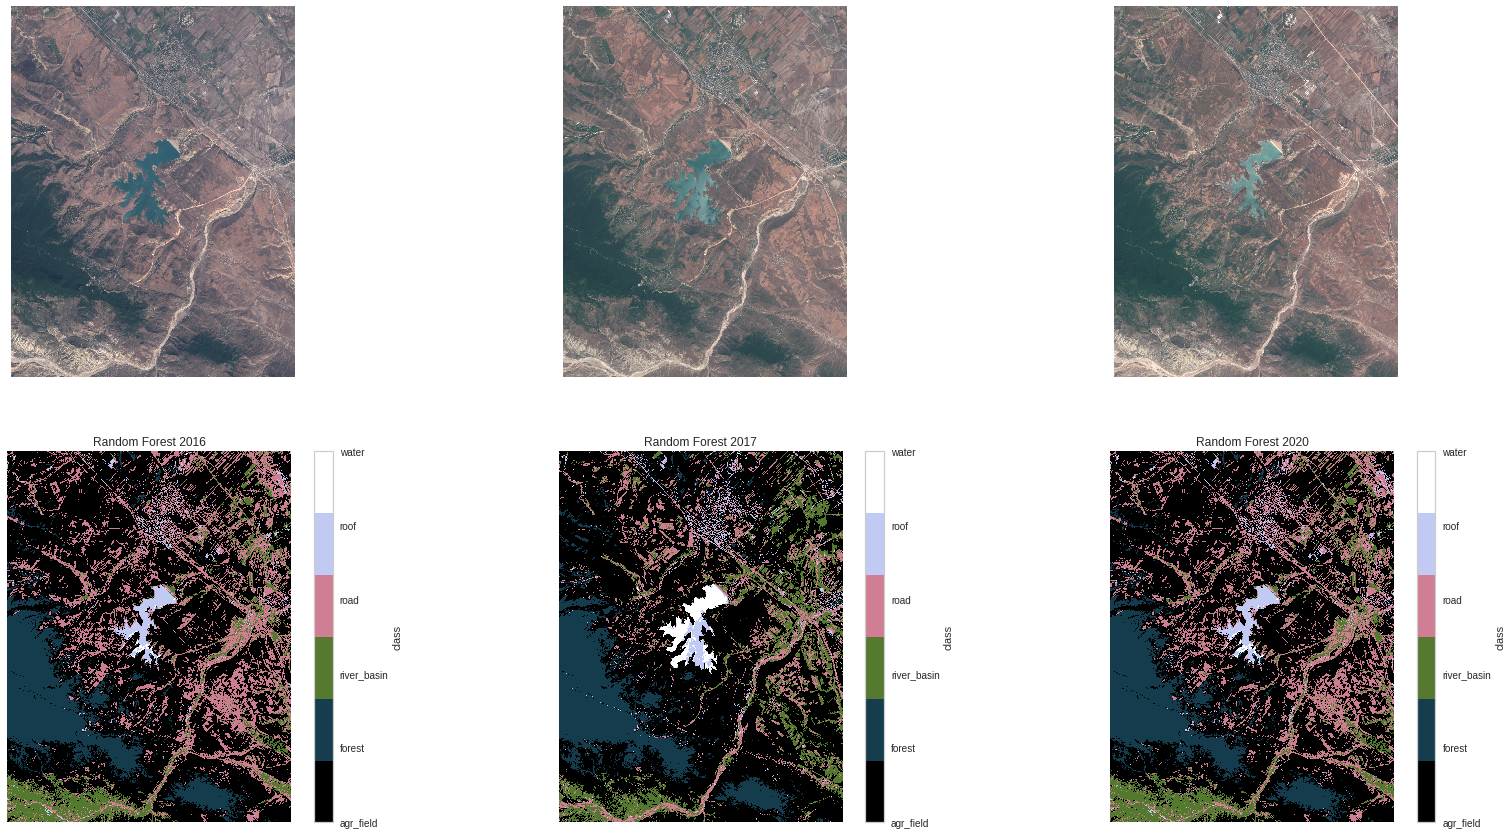

In [143]:
prd = [y_pred_img16, y_pred_img17, y_pred_img20]
img16 = mpimg.imread(rgb_fp16)
img17 = mpimg.imread(rgb_fp17)
img20 = mpimg.imread(rgb_fp20)
img = [img16, img17, img20]
fig, axs = plt.subplots(2,3,figsize=(28,15))
years = ['2016', '2017', '2020']
for i in range(3):
    axs[0, i].imshow(img[i])
    axs[0, i].set_axis_off()

    predict_plot = axs[1, i].imshow(prd[i], cmap=plt.cm.get_cmap('cubehelix', len(labels)))
    cbar = fig.colorbar(predict_plot, ax=axs[1, i], label='class')
    cbar.set_ticks(np.arange(0, len(labels)))
    cbar.set_ticklabels(labels)
    axs[1, i].set_title('Random Forest' + ' ' + years[i])
    axs[1, i].set_axis_off()

Generally result is not that good. Algorithm mostly confuses water and roof. I am not so sure about the reason however one possibility might be is this lake is an artificial one. So maybe in the bottom there are beton blocks and this is not so deep lake.

Forest was classified well, agricultural fields are generally ok. Sometime river basin and road have been confused. River basin has a lot of pebbles and it might be the reason.

Second algorithm that I am going to apply is Support Vector Classifier. 

In [145]:
from sklearn import svm
clf = make_pipeline(StandardScaler(), svm.SVC())
scores = cross_val_score(clf, X16, y16, cv=5)
scores16 = cross_val_score(clf, X17, y17, cv=5)
scores20 = cross_val_score(clf, X20, y20, cv=5)
print('Accuracy score (SVM) 2016: ', scores16.mean())
print('Accuracy score (SVM) 2017: ', scores17.mean())
print('Accuracy score (SVM) 2020: ', scores20.mean())

Accuracy score (SVM) 2016:  0.9723607936665672
Accuracy score (SVM) 2017:  0.9562762091137825
Accuracy score (SVM) 2020:  0.9658831168831169


These result already a seems little bit better than Random Forest. Now Hyperparameter tuning.

In [146]:
svm16 = GridSearchCV(estimator=clf, param_grid={'svc__C': [10, 40, 80], 'svc__gamma': [0.1, 1, 10]}, cv=10, refit=True, return_train_score=False, verbose=0)
svm17 = GridSearchCV(estimator=clf, param_grid={'svc__C': [10, 40, 80], 'svc__gamma': [0.1, 1, 10]}, cv=10, refit=True, return_train_score=False, verbose=0)
svm20 = GridSearchCV(estimator=clf, param_grid={'svc__C': [10, 40, 80], 'svc__gamma': [0.1, 1, 10]}, cv=10, refit=True, return_train_score=False, verbose=0)

svm16.fit(X16, y16)        
svm17.fit(X17, y17)        
svm20.fit(X20, y20)        
cv_results16 = pd.DataFrame(svm16.cv_results_)
cv_results16

mean_fit_time  std_fit_time  mean_score_time  std_score_time param_svc__C  \
0       0.005290      0.000944         0.000822        0.000162           10   
1       0.006384      0.000603         0.000694        0.000157           10   
2       0.016797      0.000253         0.000933        0.000011           10   
3       0.004469      0.000385         0.000571        0.000040           40   
4       0.006389      0.000156         0.000608        0.000005           40   
5       0.017168      0.000216         0.000955        0.000018           40   
6       0.004407      0.000060         0.000680        0.000463           80   
7       0.006326      0.000152         0.000605        0.000011           80   
8       0.017253      0.000248         0.000978        0.000060           80   

  param_svc__gamma                             params  split0_test_score  \
0              0.1  {'svc__C': 10, 'svc__gamma': 0.1}           0.959459   
1                1    {'svc__C': 10, 'svc__gamma': 1}           0.959459   
2               10   {'svc__C': 10, 'svc__gamma': 10}           1.000000   
3              0.1  {'svc__C': 40, 'svc__gamma': 0.1}           0.945946   
4                1    {'svc__C': 40, 'svc__gamma': 1}           0.959459   
5               10   {'svc__C': 40, 'svc__gamma': 10}           1.000000   
6              0.1  {'svc__C': 80, 'svc__gamma': 0.1}           0.945946   
7                1    {'svc__C': 80, 'svc__gamma': 1}           0.959459   
8               10   {'svc__C': 80, 'svc__gamma': 10}           1.000000   

   split1_test_score  split2_test_score  split3_test_score  split4_test_score  \
0           0.959459           0.958904           0.945205           0.972603   
1           0.945946           0.986301           0.958904           0.972603   
2           0.972973           0.986301           0.945205           0.986301   
3           0.959459           0.945205           0.945205           0.958904   
4           0.972973           0.972603           0.958904           0.972603   
5           0.972973           0.986301           0.945205           0.986301   
6           0.972973           0.945205           0.972603           0.986301   
7           0.972973           0.972603           0.958904           0.972603   
8           0.972973           0.986301           0.945205           0.986301   

   split5_test_score  split6_test_score  split7_test_score  split8_test_score  \
0           0.958904           0.986301           0.945205           0.958904   
1           0.958904           0.972603           0.958904           0.972603   
2           0.986301           0.958904           0.945205           0.972603   
3           0.958904           0.986301           0.972603           0.958904   
4           0.972603           0.958904           0.958904           0.972603   
5           0.986301           0.958904           0.945205           0.972603   
6           0.958904           0.986301           0.986301           0.958904   
7           0.972603           0.958904           0.958904           0.972603   
8           0.986301           0.958904           0.945205           0.972603   

   split9_test_score  mean_test_score  std_test_score  rank_test_score  
0           0.931507         0.957645        0.014314                9  
1           0.972603         0.965883        0.010874                5  
2           0.958904         0.971270        0.017811                1  
3           0.945205         0.957664        0.012861                8  
4           0.958904         0.965846        0.006833                7  
5           0.958904         0.971270        0.017811                1  
6           0.945205         0.965864        0.016420                6  
7           0.972603         0.967216        0.006676                4  
8           0.958904         0.971270        0.017811                1

In [147]:
svm16.best_params_, svm16.best_score_

({'svc__C': 10, 'svc__gamma': 10}, 0.9712699000370233)

In [148]:
svm17.best_params_, svm17.best_score_

({'svc__C': 10, 'svc__gamma': 10}, 0.9971264367816092)

In [149]:
svm20.best_params_, svm20.best_score_

({'svc__C': 40, 'svc__gamma': 1}, 0.9965909090909092)

Hypermarameter tuning also performed better than Random Forest. 2016 seems almost same however we have 4, 3 percent improvement in 2017 and 2020. Now let's check ourmodel with nested cross validation.

In [150]:
Acc16 = cross_val_score(svm16, X16, y16)
Acc17 = cross_val_score(svm17, X17, y17)
Acc20 = cross_val_score(svm20, X20, y20)

In [151]:
print('Nested CV 2016: ', Acc16.mean(), Acc16.std())
print('Nested CV 2017: ', Acc17.mean(), Acc17.std())
print('Nested CV 2020: ', Acc20.mean(), Acc20.std())

Nested CV 2016:  0.9562762091137825 0.007030017195313107
Nested CV 2017:  0.9959720427970453 0.005014796033200341
Nested CV 2020:  0.9943181818181819 0.005081972676135881


Now it is time for visualization of our result. As it is same script aside the algorithm, I am not going to explain steps. 

In [152]:
y_pred16 = svm16.predict(X_pred16)
y_pred17 = svm17.predict(X_pred17)
y_pred20 = svm20.predict(X_pred20)
# reshape y back to a 2D matrix for visualization
y_pred_img16 = y_pred16.reshape(orig_shape16)
y_pred_img17 = y_pred17.reshape(orig_shape17)
y_pred_img20 = y_pred20.reshape(orig_shape20)

In [153]:
labels = np.unique(shapefile17["classname"])
for i, label in enumerate(labels):
    y_pred_img16[y_pred_img16 == label] = i
    y_pred_img17[y_pred_img17 == label] = i
    y_pred_img20[y_pred_img20 == label] = i
y_pred_img16 = y_pred_img16.astype(int)
y_pred_img17 = y_pred_img17.astype(int)
y_pred_img20 = y_pred_img20.astype(int)

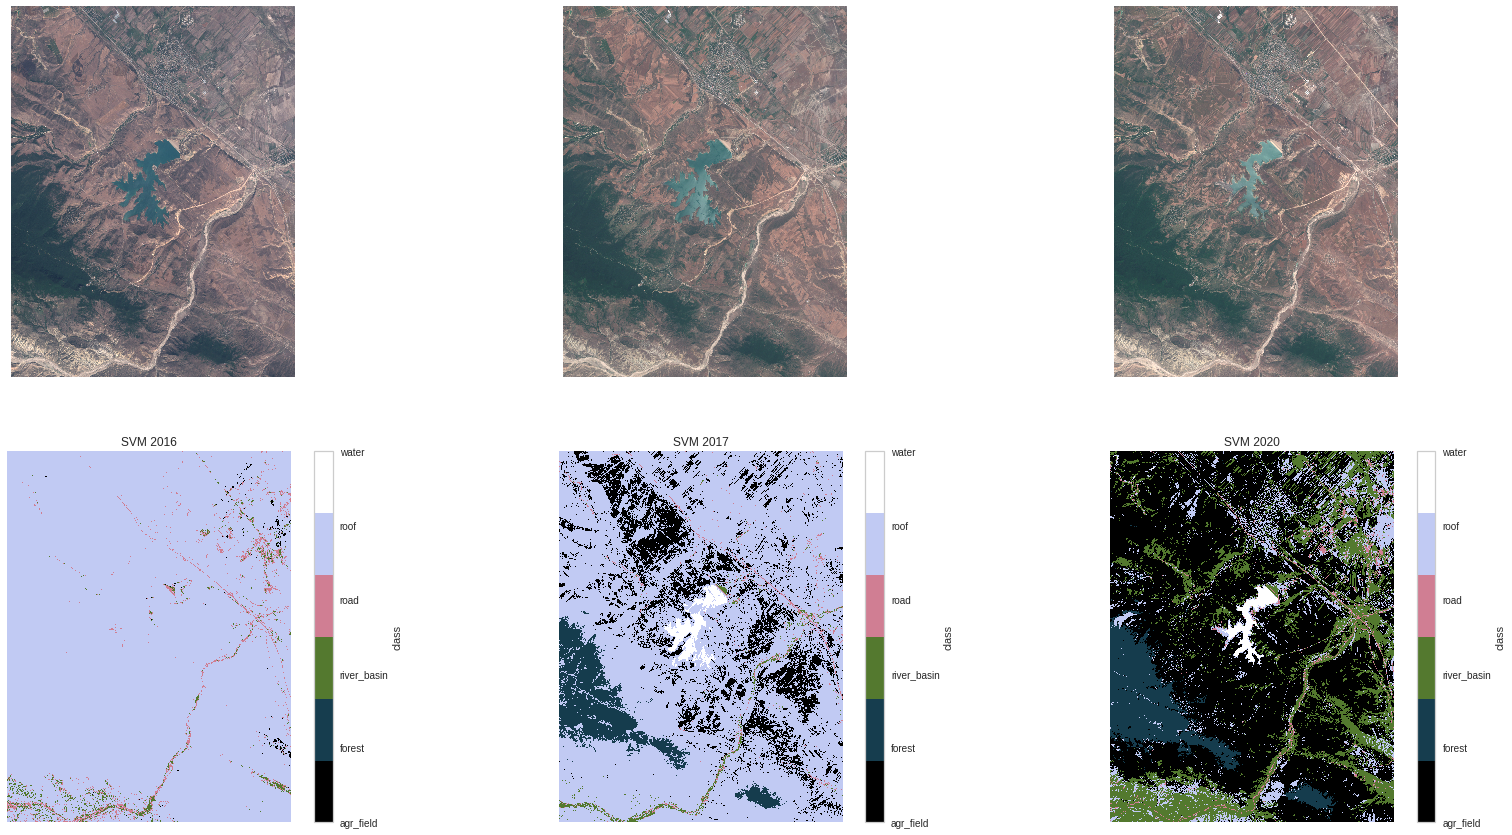

In [154]:
prd = [y_pred_img16, y_pred_img17, y_pred_img20]
img16 = mpimg.imread(rgb_fp16)
img17 = mpimg.imread(rgb_fp17)
img20 = mpimg.imread(rgb_fp20)
img = [img16, img17, img20]
fig, axs = plt.subplots(2,3,figsize=(28,15))
years = ['2016', '2017', '2020']
for i in range(3):
    axs[0, i].imshow(img[i])
    axs[0, i].set_axis_off()

    predict_plot = axs[1, i].imshow(prd[i], cmap=plt.cm.get_cmap('cubehelix', len(labels)))
    cbar = fig.colorbar(predict_plot, ax=axs[1, i], label='class')
    cbar.set_ticks(np.arange(0, len(labels)))
    cbar.set_ticklabels(labels)
    axs[1, i].set_title('SVM' + ' ' + years[i])
    axs[1, i].set_axis_off()

This is really interesting it seems like result gets better as year is increasing. 2016 is horrible, in 2017 I must say that forest, river basin and especially lake classified well. Now 2020 is really good. Lake is very clear (which was not in Random Forest) Forest and agricultural fields are quite good too. There is little bit problem with river basin but overally this is the best result of mine so far.

Next algorithm is Decision tree classifier.

In [155]:
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import make_pipeline
clf = make_pipeline(StandardScaler(), DecisionTreeClassifier())
scores16 = cross_val_score(clf, X16, y16, cv=5)
scores17 = cross_val_score(clf, X17, y17, cv=5)
scores20 = cross_val_score(clf, X20, y20, cv=5)
print('Accuracy score (Decision Tree)2016: ', scores16.mean())
print('Accuracy score (Decision Tree) 2017: ', scores17.mean())
print('Accuracy score (Decision Tree) 2020: ', scores20.mean())

Accuracy score (Decision Tree)2016:  0.9453359425962166
Accuracy score (Decision Tree) 2017:  0.9833002086852828
Accuracy score (Decision Tree) 2020:  0.9636103896103896


In [156]:
from sklearn.model_selection import GridSearchCV
import pandas as pd


dcst16 = GridSearchCV(estimator=clf, param_grid={'decisiontreeclassifier__max_depth': np.arange(4, 10), 'decisiontreeclassifier__min_samples_split': [2]}, cv=10, refit=True, return_train_score=False, verbose=0)
dcst17 = GridSearchCV(estimator=clf, param_grid={'decisiontreeclassifier__max_depth': np.arange(4, 10), 'decisiontreeclassifier__min_samples_split': [2]}, cv=10, refit=True, return_train_score=False, verbose=0)
dcst20 = GridSearchCV(estimator=clf, param_grid={'decisiontreeclassifier__max_depth': np.arange(4, 10), 'decisiontreeclassifier__min_samples_split': [2]}, cv=10, refit=True, return_train_score=False, verbose=0)

dcst16.fit(X16, y16)        
dcst17.fit(X16, y16)        
dcst20.fit(X16, y16)        

cv_results16 = pd.DataFrame(dcst16.cv_results_)
cv_results16

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0       0.002639      0.000357         0.000367        0.000038   
1       0.002660      0.000408         0.000377        0.000098   
2       0.002590      0.000253         0.000339        0.000078   
3       0.002465      0.000052         0.000260        0.000006   
4       0.002524      0.000069         0.000265        0.000022   
5       0.002720      0.000091         0.000269        0.000024   

  param_decisiontreeclassifier__max_depth  \
0                                       4   
1                                       5   
2                                       6   
3                                       7   
4                                       8   
5                                       9   

  param_decisiontreeclassifier__min_samples_split  \
0                                               2   
1                                               2   
2                                               2   
3                                               2   
4                                               2   
5                                               2   

                                              params  split0_test_score  \
0  {'decisiontreeclassifier__max_depth': 4, 'deci...           0.932432   
1  {'decisiontreeclassifier__max_depth': 5, 'deci...           0.878378   
2  {'decisiontreeclassifier__max_depth': 6, 'deci...           0.972973   
3  {'decisiontreeclassifier__max_depth': 7, 'deci...           0.959459   
4  {'decisiontreeclassifier__max_depth': 8, 'deci...           0.959459   
5  {'decisiontreeclassifier__max_depth': 9, 'deci...           0.959459   

   split1_test_score  split2_test_score  split3_test_score  split4_test_score  \
0           0.891892           0.890411           0.821918           0.890411   
1           0.891892           0.917808           0.849315           0.904110   
2           0.918919           0.945205           0.876712           0.958904   
3           0.905405           0.958904           0.876712           0.958904   
4           0.918919           0.958904           0.876712           0.958904   
5           0.932432           0.958904           0.876712           0.958904   

   split5_test_score  split6_test_score  split7_test_score  split8_test_score  \
0           0.931507           0.904110           0.931507           0.917808   
1           0.931507           0.890411           0.917808           0.931507   
2           0.958904           0.945205           0.876712           0.945205   
3           0.972603           0.945205           0.863014           0.945205   
4           0.986301           0.945205           0.876712           0.958904   
5           0.986301           0.945205           0.876712           0.972603   

   split9_test_score  mean_test_score  std_test_score  rank_test_score  
0           0.863014         0.897501        0.033201                6  
1           0.890411         0.900315        0.024334                5  
2           0.931507         0.933025        0.031502                3  
3           0.931507         0.931692        0.035667                4  
4           0.904110         0.934413        0.036129                2  
5           0.917808         0.938504        0.035868                1

In [157]:
dcst16.best_params_, dcst16.best_score_

({'decisiontreeclassifier__max_depth': 9,
  'decisiontreeclassifier__min_samples_split': 2},
 0.9385042576823398)

In [158]:
dcst17.best_params_, dcst17.best_score_

({'decisiontreeclassifier__max_depth': 9,
  'decisiontreeclassifier__min_samples_split': 2},
 0.9412254720473898)

In [159]:
dcst20.best_params_, dcst20.best_score_

({'decisiontreeclassifier__max_depth': 9,
  'decisiontreeclassifier__min_samples_split': 2},
 0.9371714179933358)

Hyperparameter tuning did not provide any better result.

In [244]:
Acc16 = cross_val_score(dcst16, X16, y16)
Acc17 = cross_val_score(dcst17, X17, y17)
Acc20 = cross_val_score(dcst20, X20, y20)

In [245]:
print('Nested CV: ', Acc16.mean(), Acc16.std())
print('Nested CV: ', Acc17.mean(), Acc17.std())
print('Nested CV: ', Acc20.mean(), Acc20.std())

Nested CV:  0.9412356723511323 0.011221525300065554
Nested CV:  0.9815810394514557 0.0076283453854184575
Nested CV:  0.967012987012987 0.014979957937898787


In [246]:
y_pred16 = dcst16.predict(X_pred16)
y_pred17 = dcst17.predict(X_pred17)
y_pred20 = dcst20.predict(X_pred20)
# reshape y back to a 2D matrix for visualization
y_pred_img16 = y_pred16.reshape(orig_shape16)
y_pred_img17 = y_pred17.reshape(orig_shape17)
y_pred_img20 = y_pred20.reshape(orig_shape20)

In [247]:
labels = np.unique(shapefile17["classname"])
for i, label in enumerate(labels):
    y_pred_img16[y_pred_img16 == label] = i
    y_pred_img17[y_pred_img17 == label] = i
    y_pred_img20[y_pred_img20 == label] = i
y_pred_img16 = y_pred_img16.astype(int)
y_pred_img17 = y_pred_img17.astype(int)
y_pred_img20 = y_pred_img20.astype(int)

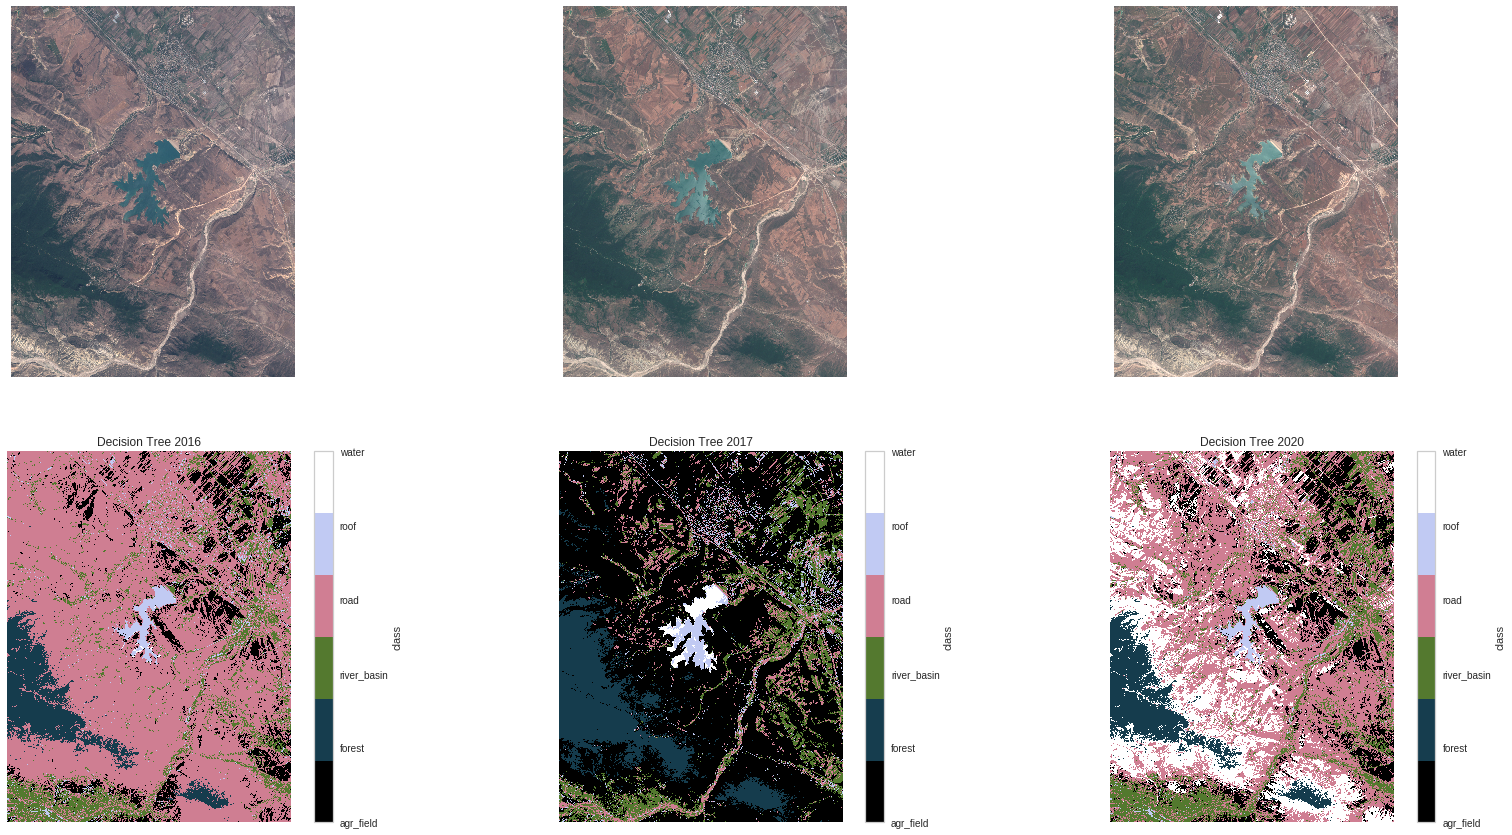

In [249]:
prd = [y_pred_img16, y_pred_img17, y_pred_img20]
img16 = mpimg.imread(rgb_fp16)
img17 = mpimg.imread(rgb_fp17)
img20 = mpimg.imread(rgb_fp20)
img = [img16, img17, img20]
fig, axs = plt.subplots(2,3,figsize=(28,15))
years = ['2016', '2017', '2020']
for i in range(3):
    axs[0, i].imshow(img[i])
    axs[0, i].set_axis_off()

    predict_plot = axs[1, i].imshow(prd[i], cmap=plt.cm.get_cmap('cubehelix', len(labels)))
    cbar = fig.colorbar(predict_plot, ax=axs[1, i], label='class')
    cbar.set_ticks(np.arange(0, len(labels)))
    cbar.set_ticklabels(labels)
    axs[1, i].set_title('Decision Tree' + ' ' + years[i])
    axs[1, i].set_axis_off()

Results still are not good. 2017 seems little bit better but still not good enough. Overally I must say that among all algorithms Random forest performed best in 2016. However Best result was SVM 2017.

Now we will train CNN with Eurosat images and apply to our region of interest.

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import os
import numpy as np
import matplotlib.image as mpimg
import rasterio
from sklearn.model_selection import train_test_split
import tensorflow as tf

First step is creating list of label names by using os.listdir(). Then we will check number of images and visualize some of them.

In [2]:
# folder containing eurosat rgb images
DATA_DIRECTORY = '05_eurosat_rgb'

# each subfolder corresponds to a class
label_names = os.listdir(DATA_DIRECTORY)
print('Labels: {}'.format(label_names))

Labels: ['Industrial', 'Highway', 'Forest', 'HerbaceousVegetation', 'AnnualCrop', 'River', 'PermanentCrop', 'Residential', 'SeaLake', 'Pasture']


In [3]:
# get number of images per label
c = 0
for label in label_names:
    files = os.listdir(DATA_DIRECTORY + '/' + label)
    n_files = len(files)
    c += n_files
    print('{}: {}'.format(label, n_files))
print('\nTotal number of images: {}'.format(c))

Industrial: 1000
Highway: 1000
Forest: 1000
HerbaceousVegetation: 1000
AnnualCrop: 1000
River: 1000
PermanentCrop: 1000
Residential: 1000
SeaLake: 1000
Pasture: 1000

Total number of images: 10000


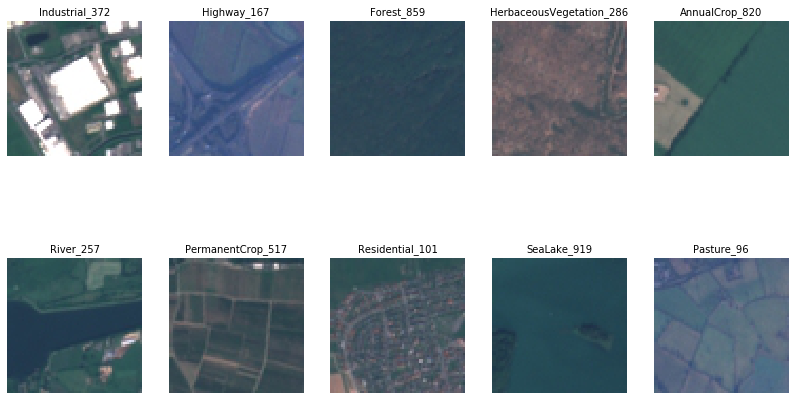

In [4]:
np.random.seed(0)
fig, axs = plt.subplots(2, 5, figsize = (14, 8))
DATA_DIRECTORY = '05_eurosat_rgb'
label_dirs = [DATA_DIRECTORY + '/' + label + '/' for label in label_names]
for label_dir, ax in zip(label_dirs, axs.flatten()):
    fnames = os.listdir(label_dir)
    fname = np.random.choice(fnames)
    img = mpimg.imread(label_dir + fname)
    ax.imshow(img)   
    ax.set_title(fname[:-4], fontsize=10)
    ax.set_axis_off()

In [5]:
# label <-> integer
labels = ['Forest', 'River', 'Highway', 'AnnualCrop', 'SeaLake', 'HerbaceousVegetation', 
          'Industrial', 'Residential', 'PermanentCrop', 'Pasture'] 
label_dict = dict(zip(labels, np.arange(len(labels), dtype=int)))
reverse_label_dict = dict(map(reversed, label_dict.items()))
def create_X_y(DATA_DIRECTORY):
    label_names = os.listdir(DATA_DIRECTORY)
    label_dirs = [DATA_DIRECTORY + '/' + label + '/' for label in label_names]
    X = []
    y = []
    for label_dir in label_dirs:
        print(label_dir)
        fnames = os.listdir(label_dir)
        for fname in fnames:
            label = fname.split('_')[0]
            yi = label_dict[label]
            y.append(yi)
            if DATA_DIRECTORY == '05_eurosat_rgb':
                Xi = mpimg.imread(label_dir + fname)
            elif DATA_DIRECTORY == '05_eurosat_all':
                Xi = rasterio.open(label_dir + fname).read()
                Xi = np.moveaxis(Xi, 0, -1)
            X.append(Xi)
    X = np.asarray(X)
    y = np.asarray(y)
    return X, y
X, y = create_X_y('05_eurosat_rgb')

05_eurosat_rgb/Industrial/
05_eurosat_rgb/Highway/
05_eurosat_rgb/Forest/
05_eurosat_rgb/HerbaceousVegetation/
05_eurosat_rgb/AnnualCrop/
05_eurosat_rgb/River/
05_eurosat_rgb/PermanentCrop/
05_eurosat_rgb/Residential/
05_eurosat_rgb/SeaLake/
05_eurosat_rgb/Pasture/


In [6]:
print(X.shape, X.dtype, X.min(), X.max())
print(y.shape, y.dtype)

(10000, 64, 64, 3) uint8 5 255
(10000,) int64


Shape of images are (64, 64, 3). 3 stands for RGB and each image has shape 64 to 64. These number are important especially when we will apply our model to our chosen area.

In [7]:
print(X[0, :, :, 0])
print(np.unique(y, return_counts=True))

[[ 92  91  89 ... 119 106 109]
 [ 92  94  94 ... 122 107 109]
 [127 130 137 ... 127 120 115]
 ...
 [ 84  85  76 ... 127 124 123]
 [ 77  78  71 ... 129 134 129]
 [ 56  57  59 ... 110 139 147]]
(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), array([1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000]))


Next step is splitting data to traning and testing parts. We are defining test_size argument 0.2 which means we will train our algorithm with 80 percent of data and last 20 percents is for validation. 

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=0)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)
print(np.unique(y_train, return_counts=True)[1]/len(y_train))
print(np.unique(y_test, return_counts=True)[1]/len(y_test))

(8000, 64, 64, 3) (8000,) (2000, 64, 64, 3) (2000,)
[0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
[0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]


Next step is normalization of RGB values. We have to divide values to the maximum value which is 255.

In [9]:
X_train, X_test = X_train/255., X_test/255.
print(X_train.min(), X_train.max(), X_test.min(), X_test.max())
X_test.dtype

0.0196078431372549 1.0 0.06274509803921569 1.0


dtype('float64')

Building model from what I understand is more intuitive. However nowing layers and using them in right place will increase our models precision. For homeworks we all gave little description with our own words so I will not repeat them again. 

For final project I am using 2 different models. I am using my models from homework as I got over 85 percent score with both models (I tried a lot of different models and these 2 are my best models). 



In [10]:
ths = {}

In [11]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(16, kernel_size=(3, 3), activation='relu', padding='same', input_shape=(64, 64, 3)),
    tf.keras.layers.Conv2D(16, kernel_size=(3, 3), activation='relu', padding='same'),
    tf.keras.layers.Conv2D(16, kernel_size=(3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2),strides=2),
    tf.keras.layers.Dropout(.2),
    tf.keras.layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    tf.keras.layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(3, 3),strides=2),
    tf.keras.layers.Dropout(.3),
    tf.keras.layers.Conv2D(96, kernel_size=(5, 5), activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2),strides=2),
    tf.keras.layers.Dropout(.5),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1024, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(.75),
    tf.keras.layers.Dense(10)
])

# summary of entire model
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 64, 64, 16)        448       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 16)        2320      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 16)        2320      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 32, 32, 16)        0         
_________________________________________________________________
dropout (Dropout)            (None, 32, 32, 16)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 30, 30, 64)        9280      
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 28, 28, 64)        3

In [12]:
%%time
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=50, validation_data=(X_test, y_test))
ths['3xCCPD'] = history

Epoch 1/50
250/250 [==============================] - 62s 249ms/step - loss: 1.7292 - accuracy: 0.3281 - val_loss: 2.2719 - val_accuracy: 0.1270
Epoch 2/50
250/250 [==============================] - 63s 250ms/step - loss: 1.3876 - accuracy: 0.4762 - val_loss: 1.6131 - val_accuracy: 0.4200
Epoch 3/50
250/250 [==============================] - 63s 251ms/step - loss: 1.2082 - accuracy: 0.5561 - val_loss: 1.6386 - val_accuracy: 0.3895
Epoch 4/50
250/250 [==============================] - 65s 262ms/step - loss: 1.0714 - accuracy: 0.6126 - val_loss: 1.2075 - val_accuracy: 0.5540
Epoch 5/50
250/250 [==============================] - 66s 263ms/step - loss: 1.0153 - accuracy: 0.6349 - val_loss: 0.8628 - val_accuracy: 0.6800
Epoch 6/50
250/250 [==============================] - 65s 259ms/step - loss: 0.9010 - accuracy: 0.6790 - val_loss: 0.9388 - val_accuracy: 0.6525
Epoch 7/50
250/250 [==============================] - 66s 263ms/step - loss: 0.8785 - accuracy: 0.6849 - val_loss: 0.6847 - val_ac

Here I got ~87 percent of validation accuracy. One important point is every time I am running my model I am getting different results. I found a couple of suggestions on the internet to avoid that but it seems that there is not a clear path. Also from my little experience, I think even the inconsistency will not be too big. For example, the will not be 10 percent score difference.

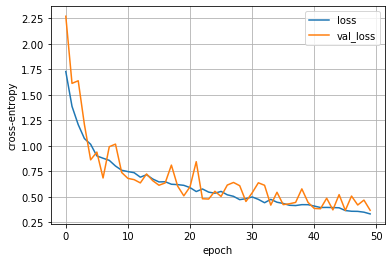

In [14]:
fig, ax = plt.subplots()
ax.plot(history.history['loss'], label='loss')
ax.plot(history.history['val_loss'], label='val_loss')
ax.set_xlabel('epoch')
ax.set_ylabel('cross-entropy')
ax.legend()
ax.grid()

In [15]:
model.evaluate(X_test, y_test, verbose=2)

63/63 - 2s - loss: 0.3675 - accuracy: 0.8730


[0.367509126663208, 0.8730000257492065]

In [36]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(16, kernel_size=(3, 3), activation='relu', padding='same', input_shape=(64, 64, 3)),
    tf.keras.layers.Conv2D(16, kernel_size=(3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D(pool_size=(4, 4),strides=2),
    tf.keras.layers.Dropout(.3),
    tf.keras.layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    tf.keras.layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(4, 4),strides=2),
    tf.keras.layers.Dropout(.5),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(.7),
    tf.keras.layers.Dense(10)])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 64, 64, 16)        448       
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 64, 64, 16)        2320      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 31, 31, 16)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 31, 31, 16)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 29, 29, 64)        9280      
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 27, 27, 64)        36928     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 12, 12, 64)       

In [37]:
%%time
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'])
history = model.fit(X_train, y_train, epochs=50, validation_data=(X_test, y_test))
ths['2xCCPD_512'] = history

Epoch 1/50
250/250 [==============================] - 45s 179ms/step - loss: 1.7202 - accuracy: 0.4053 - val_loss: 1.9213 - val_accuracy: 0.3085
Epoch 2/50
250/250 [==============================] - 44s 178ms/step - loss: 1.0556 - accuracy: 0.6234 - val_loss: 1.0757 - val_accuracy: 0.6400
Epoch 3/50
250/250 [==============================] - 45s 180ms/step - loss: 0.8642 - accuracy: 0.6935 - val_loss: 1.1754 - val_accuracy: 0.6045
Epoch 4/50
250/250 [==============================] - 44s 177ms/step - loss: 0.7539 - accuracy: 0.7352 - val_loss: 0.9865 - val_accuracy: 0.6545
Epoch 5/50
250/250 [==============================] - 44s 175ms/step - loss: 0.6981 - accuracy: 0.7585 - val_loss: 1.0587 - val_accuracy: 0.6745
Epoch 6/50
250/250 [==============================] - 44s 176ms/step - loss: 0.6628 - accuracy: 0.7689 - val_loss: 0.8131 - val_accuracy: 0.7285
Epoch 7/50
250/250 [==============================] - 44s 176ms/step - loss: 0.6109 - accuracy: 0.7847 - val_loss: 0.5503 - val_ac

Our second model's score is ~87 percent. There is no big difference between two models.

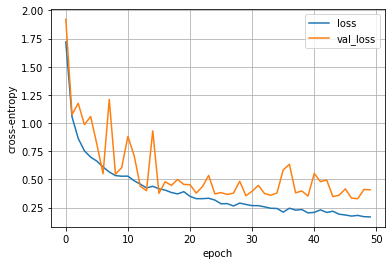

In [38]:
fig, ax = plt.subplots()
ax.plot(history.history['loss'], label='loss')
ax.plot(history.history['val_loss'], label='val_loss')
ax.set_xlabel('epoch')
ax.set_ylabel('cross-entropy')
ax.legend()
ax.grid()

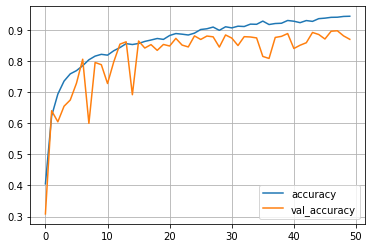

In [39]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.legend()
plt.grid()

In [40]:
model.evaluate(X_test, y_test, verbose=2)

63/63 - 2s - loss: 0.4078 - accuracy: 0.8695


[0.4077550768852234, 0.8694999814033508]

In [41]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [42]:
model.evaluate(X_test, y_test, verbose=2)

63/63 - 2s - loss: 0.4078 - accuracy: 0.8695


[0.4077550768852234, 0.8694999814033508]

Now before appyling our model to our chosen area we can check how model performs (visually) on EuroSat data it self. For that first we will define some random indices for choosing random images.

In [16]:
np.random.seed(0)

In [17]:
idx = np.random.randint(len(X_test), size=20)
X_test.dtype

dtype('float64')

In [18]:
y_pred_logit = model(X_test.astype('float32')[idx]).numpy()

Model will give the results as logits or log-odds. 'softmax' function will normalize probability distribution over predicted output classes (Wikipedia). In the end we will get outputs like inputs.

In [19]:
y_pred = tf.nn.softmax(y_pred_logit).numpy()
print(y_pred.argmax(axis=1))
print(y_test[idx])

[3 1 9 4 2 6 1 5 5 4 9 6 6 7 7 7 6 3 4 0]
[3 1 9 4 2 6 1 5 5 4 9 6 6 7 7 5 6 3 4 0]


Index number 15 was predicted wrong. We can check visually by using same indices.

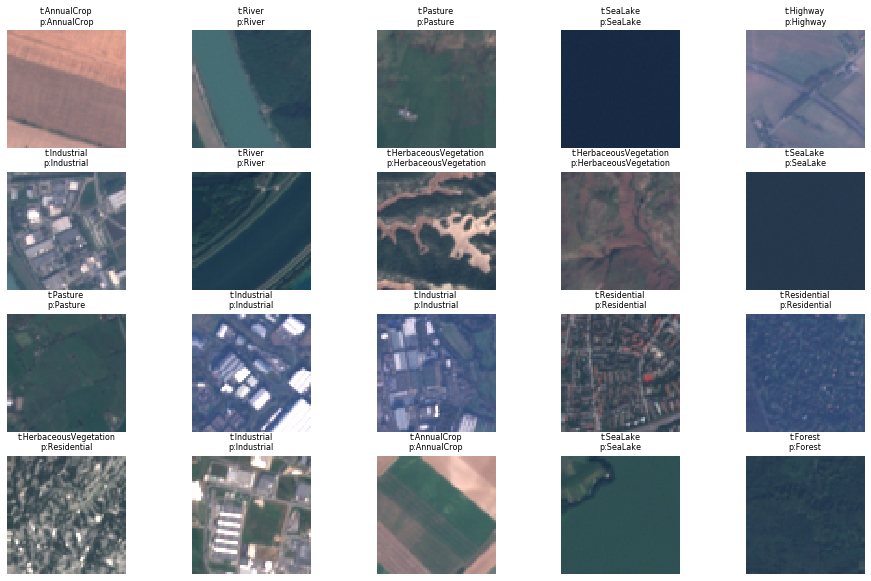

In [20]:
fig, axs = plt.subplots(4, 5, figsize=(16, 10))
for X_test_i, y_test_i, y_pred_i, ax in zip(X_test[idx], y_test[idx], y_pred, axs.flatten()):
    ax.imshow(X_test_i)
    true_label = reverse_label_dict[y_test_i]
    pred_label = reverse_label_dict[y_pred_i.argmax()]
    ax.set_title('t:{}\np:{}'.format(true_label, pred_label), fontsize=8)
    ax.set_axis_off()

Herbaceous Vegetation predicted as Residential.

Now we can check our model's performance on our images. Just for the record this time we will not plot the whole classified image. We will choose some random scenes (64x64) and we will apply our model to these scenes. The reason is before we were had labelled polygons (pixels) and each polygon was representing ONLY 1 object. However, with Eurosat images we have images which have more complications. Some images like highway do not contain only highway but also the surrounding area. One idea could be dividing the whole image to continuous tiles (64x64) and applying an algorithm for getting the whole classified image, which is not maybe the best idea to do. In this case I am going to check tiles seperately.

In [21]:
sentinel_fp16 = 'siyazan16.jpg'
img16 = mpimg.imread(sentinel_fp16) 
sentinel_fp17 = 'siyazan17.jpg'
img17 = mpimg.imread(sentinel_fp17) 
sentinel_fp20 = 'siyazan20.jpg'
img20 = mpimg.imread(sentinel_fp20) 

In [22]:
img16 = img16 / 255.
img17 = img17 / 255.
img20 = img20 / 255.
print(img.dtype)

uint8


First step is defining window size and creating empty lists for filling them with tiles.

In [29]:
windowSize = 64
tiles16, tiles17, tiles20 = [], [], []

Little bit about the code. When we are looping by row our range is from zero to number of rows of our image with step size of 64 (window size). We are applying same idea to columns. Then we are creating tile by row/column + window size. But as our images might have remainder so we are adding little condition to our loop '... == windowSize'.

Last line is just converting list to a numpy array. Numpy arrays are way faster and has some advantages in complicated indexing operations.

In [30]:
for row in range(0, img16.shape[0], windowSize):
    for col in range(0, img16.shape[1], windowSize):
        
        img_tile = img16[row : row + windowSize, col : col + windowSize, :]
        if img_tile.shape[0] == windowSize and img_tile.shape[1] == windowSize:
            tiles16.append(img_tile)
tiles16 = np.asarray(tiles16)

In [31]:
for row in range(0, img17.shape[0], windowSize):
    for col in range(0, img17.shape[1], windowSize):
        img_tile17 = img17[row : row + windowSize, col : col + windowSize, :]        
        if img_tile17.shape[0] == windowSize and img_tile17.shape[1] == windowSize:
            tiles17.append(img_tile17)
tiles17 = np.asarray(tiles17)

In [32]:
for row in range(0, img20.shape[0], windowSize):
    for col in range(0, img20.shape[1], windowSize):
        img_tile20 = img20[row : row + windowSize, col : col + windowSize, :]
        if img_tile20.shape[0] == windowSize and img_tile20.shape[1] == windowSize:
            tiles20.append(img_tile20)
tiles20 = np.asarray(tiles20)

Now we can predict some random tiles and visualize them. First we create random indices and it is important to remind that we should not create new indices for each year as we want to see same tiles from every year (for possible different prediction results and surface changes).

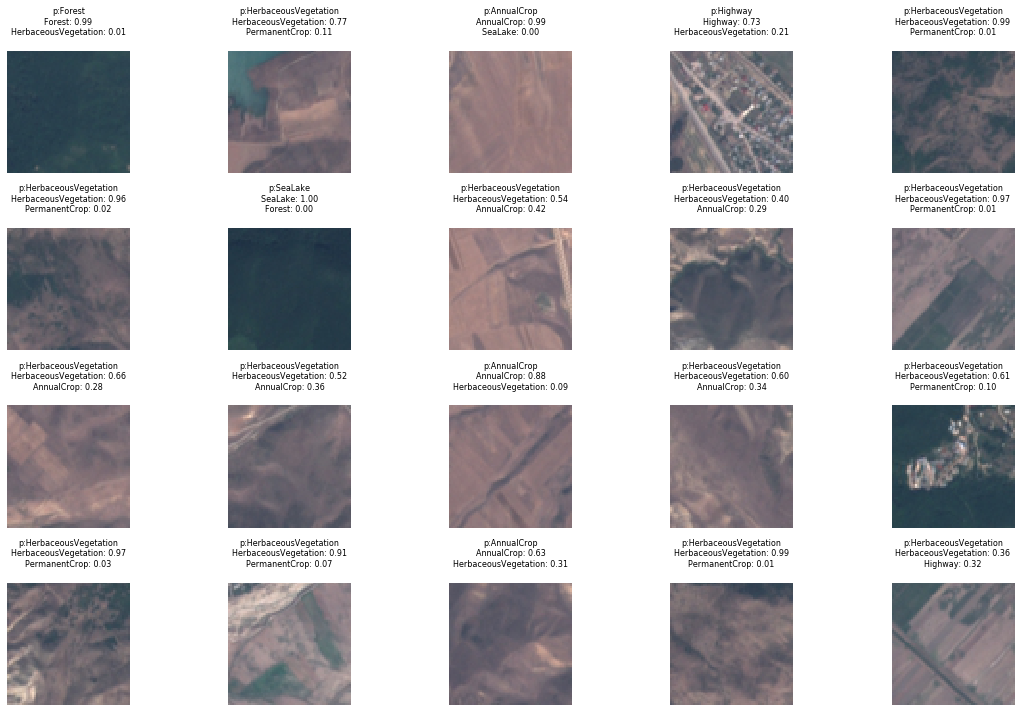

In [33]:
idx = np.random.randint(len(tiles16), size=20)
y_pred_logit_tiles16 = model(tiles16[idx].astype('float32')).numpy()
y_pred_tiles16 = tf.nn.softmax(y_pred_logit_tiles16).numpy()
fig, axs = plt.subplots(4, 5, figsize=(16, 10))
for tile_i, y_pred_i, ax in zip(tiles16[idx], y_pred_tiles16, axs.flatten()):
    ax.imshow(tile_i)
    ilabels = y_pred_i.argsort()[::-1][:2]
    ivalues = np.sort(y_pred_i)[::-1][:2]
    slabels = [reverse_label_dict[ilab] for ilab in ilabels]
    class_probs = '{}: {:.2f}\n{}: {:.2f}\n'.format(slabels[0], ivalues[0], slabels[1], ivalues[1])
    pred_label = reverse_label_dict[y_pred_i.argmax()]
    ax.set_title('p:{}\n{}'.format(pred_label, class_probs), fontsize=8)
    ax.set_axis_off()
fig.tight_layout()

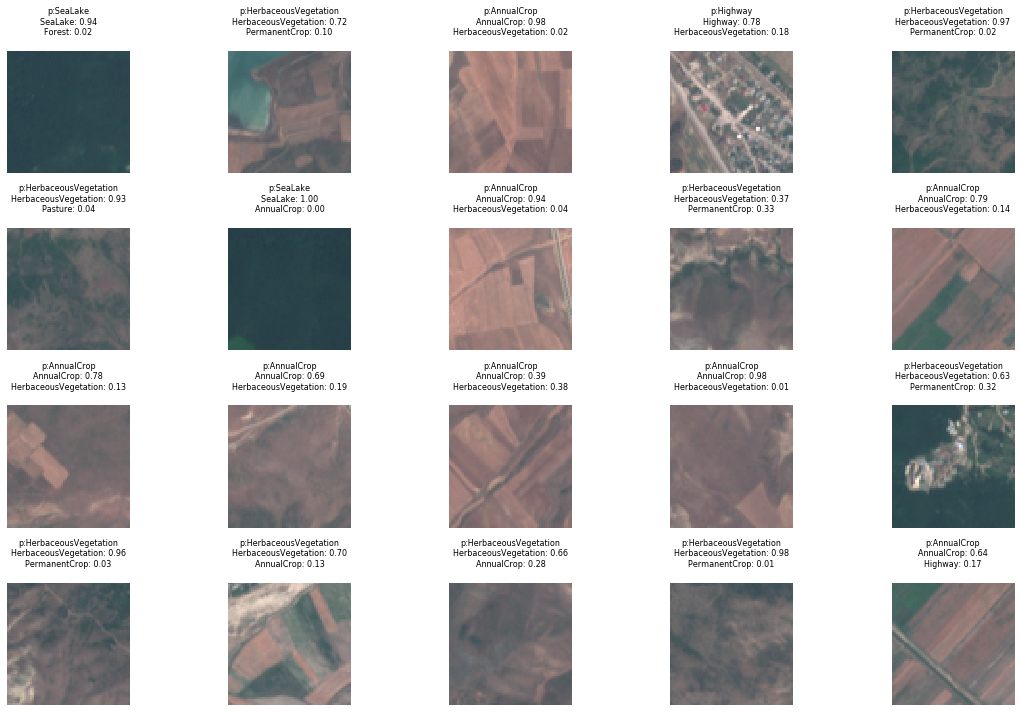

In [34]:
#idx = np.random.randint(len(tiles17), size=20)
y_pred_logit_tiles17 = model(tiles17[idx].astype('float32')).numpy()
y_pred_tiles17 = tf.nn.softmax(y_pred_logit_tiles17).numpy()
fig, axs = plt.subplots(4, 5, figsize=(16, 10))
for tile_i, y_pred_i, ax in zip(tiles17[idx], y_pred_tiles17, axs.flatten()):
    ax.imshow(tile_i)
    ilabels = y_pred_i.argsort()[::-1][:2]
    ivalues = np.sort(y_pred_i)[::-1][:2]
    slabels = [reverse_label_dict[ilab] for ilab in ilabels]
    class_probs = '{}: {:.2f}\n{}: {:.2f}\n'.format(slabels[0], ivalues[0], slabels[1], ivalues[1])
    pred_label = reverse_label_dict[y_pred_i.argmax()]
    ax.set_title('p:{}\n{}'.format(pred_label, class_probs), fontsize=8)
    ax.set_axis_off()
fig.tight_layout()

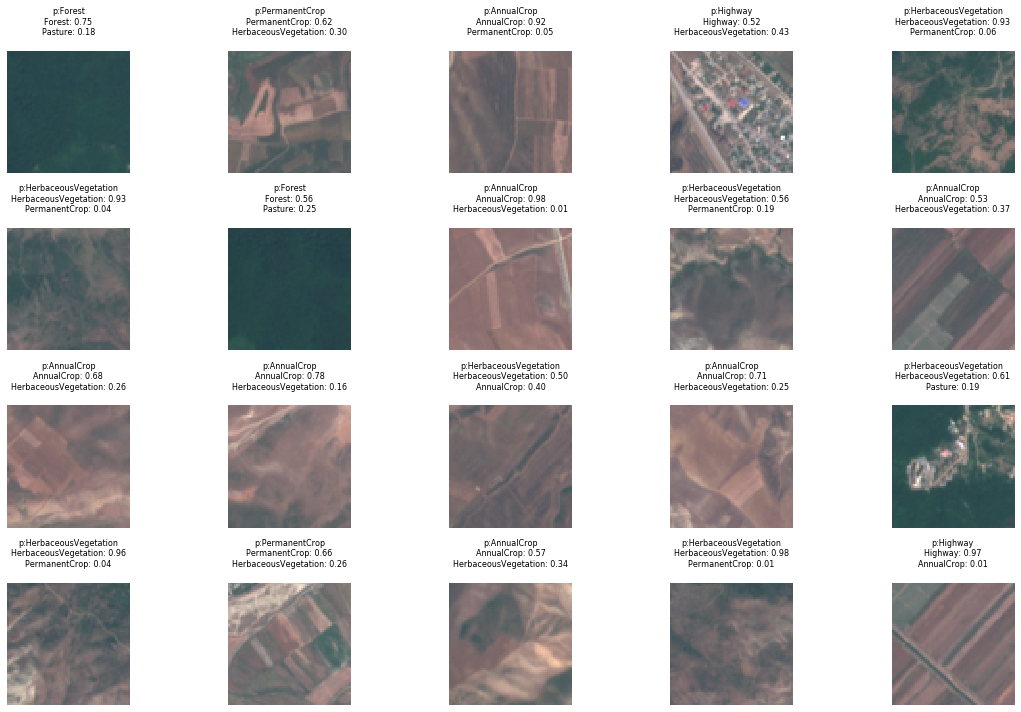

In [35]:
#idx = np.random.randint(len(tiles20), size=20)
y_pred_logit_tiles20 = model(tiles20[idx].astype('float32')).numpy()
y_pred_tiles20 = tf.nn.softmax(y_pred_logit_tiles20).numpy()
fig, axs = plt.subplots(4, 5, figsize=(16, 10))
for tile_i, y_pred_i, ax in zip(tiles20[idx], y_pred_tiles20, axs.flatten()):
    ax.imshow(tile_i)
    ilabels = y_pred_i.argsort()[::-1][:2]
    ivalues = np.sort(y_pred_i)[::-1][:2]
    slabels = [reverse_label_dict[ilab] for ilab in ilabels]
    class_probs = '{}: {:.2f}\n{}: {:.2f}\n'.format(slabels[0], ivalues[0], slabels[1], ivalues[1])
    pred_label = reverse_label_dict[y_pred_i.argmax()]
    ax.set_title('p:{}\n{}'.format(pred_label, class_probs), fontsize=8)
    ax.set_axis_off()
fig.tight_layout()

Overally the result is not good. There is not a lot that I can say about it. Only thing that in the second image [0, 1] in 2016 and 2017 there was lake but in 2020 there is not (because of the drought). But SeaLake class name was not even among the probabilities.

For improving predictions using dataset with more classes is very crucial. Also here for each class we have 1000 however more images for each class might improve our results (also image augmentation or using pretrained models might be very useful too).

Difference between image based and pixel based classification -- in pixel based we have more certainty as each pixel has only one label. However image tiles can be more complex and finding features are more complicated (as they might contain multiple classes in one image) in contrary being able classify more complex scenes is really exciting. However limitation about pixel based classification is creating classes manually. Also noisy data can cause problems in this kind of classification approaches too (See my results). 